# CAPSTONE3 Application of Deep Learning for the Stability Prediction of the Smart Grids

# Tables of Contents

## 1 Introduction
### 1.1 Problem statement
### 1.2 Dataset
### 1.3 Study object and goal

## 2 Data Wrangling
### 2.1 Data collection
### 2.2 Data definition

## 3 Exploratory Data Analysis
### 3.1 Inferential statistics
### 3.2 3.2 Hypothesis tests

## 4 Pre-processing and Training Data
### 4.1 Customized functions
### 4.2 Correlation
### 4.3 Segregating train and test sets
### 4.4 Feature assessing and scaling

## 5 Deep Learning
### 5.1 Model definition
### 5.2 Model fitting

# 1 Introduction<a id='1_Introduction'></a>

## 1.1 Problem Statement<a id='1.1_Problem Statement'></a>

Decentral Smart Grid Control (DSGC) is a new system implementing demand response without significant changes of the power grid infrastructure. It does so by binding the electricity price to the grid frequency, which is one of the most important factors of the power grid stability[1][2]. The theoretical model of the power grid system made some simplifications to monitor and control the operation of the power grids. With the development of data collection and data mining, it is possible to use deep learning methods to predict the stability of a four-node-star electrical grid with a centralized production system. This project will develop a deep learning model for this four-node-star electrical grid with a centralized production that the precision is more than 90% to predict the stability of this power grid.

## 1.2 Dataset<a id='1.2_Dataset'></a>

The dataset, created by KIT, contains results from simulations of grid stability for a reference 4-node star power grid. This power grid system is the most common power grid system in the world. The original dataset contains 10,000 observations and includes 12 primary predictive features and two dependent variables. The parameters and status were recorded for about 2 months with a ten-minute interval, which include stable and unstable scenarios. 

The original dataset contains 10,000 observations. As the reference grid is symetric, the dataset can be augmented in 3! (3 factorial) times, or 6 times, representing a permutation of the three consumers occupying three consumer nodes. The augmented version has then 60,000 observations. It also contains 12 primary predictive features and two dependent variables.

**Predictive features:**

'tau1' to 'tau4': the reaction time of each network participant;

'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant;

'g1' to 'g4': price elasticity coefficient for each network participant;

**Dependent variables:**

'stab': the maximum real part of the characteristic differentia equation root (if positive, the system is linearly unstable; if negative, linearly stable);

'stabf': a categorical (binary) label ('stable' or 'unstable').

## 1.3 Study object and goal<a id='1.3_Study object and goal'></a>

In a smart grid, consumer demand information is collected, centrally evaluated against current supply conditions and the resulting proposed price information is sent back to customers for them to decide about usage. As the whole process is time-dependent, dinamically estimating **grid stability** becomes not only a concern but a major requirement.

Put simply, the objective is to understand and plan for both energy production and/or consumption disturbances and fluctuations introduced by system participants in a dynamic way, taking into consideration not only technical aspects but also how participants respond to changes in the associated economic aspects (energy price).

The work of researchers cited in foreword focuses on **Decentral Smart Grid Control (DSGC)** systems, a methodology strictly tied to monitoring one particular property of the grid - its frequency.

The term 'frequency' refers to the alternate current (AC) frequency, measured in cycles per second or its equivalent unit, Hertz (Hz). Around the world AC frequencies of either 50 or 60 Hz are utilized in electric power generation-distribution systems.

It is known that the electrical signal frequency "increases in times of excess generation, while it decreases in times of underproduction" [1]. Therefore, **measuring the grid frequency** at the premise of each customer would suffice to provide the network administrator with all required information about the current **network power balance**, so that it can price its energy offering - and inform consumers - accordingly.

The DSGC differential equation-based mathematical model described in [1] and assessed in [2] aims at identifying grid instability for a reference **4-node star** architecture, comprising one power source (a centralized generation node) supplying energy to three consumption nodes. The model takes into consideration inputs (features) related to:

- the total **power balance** (nominal power produced or consumed at each grid node);
- the response time of participants to adjust consumption and/or production in response to price changes (referred to as "**reaction time**");
- energy **price elasticity**.

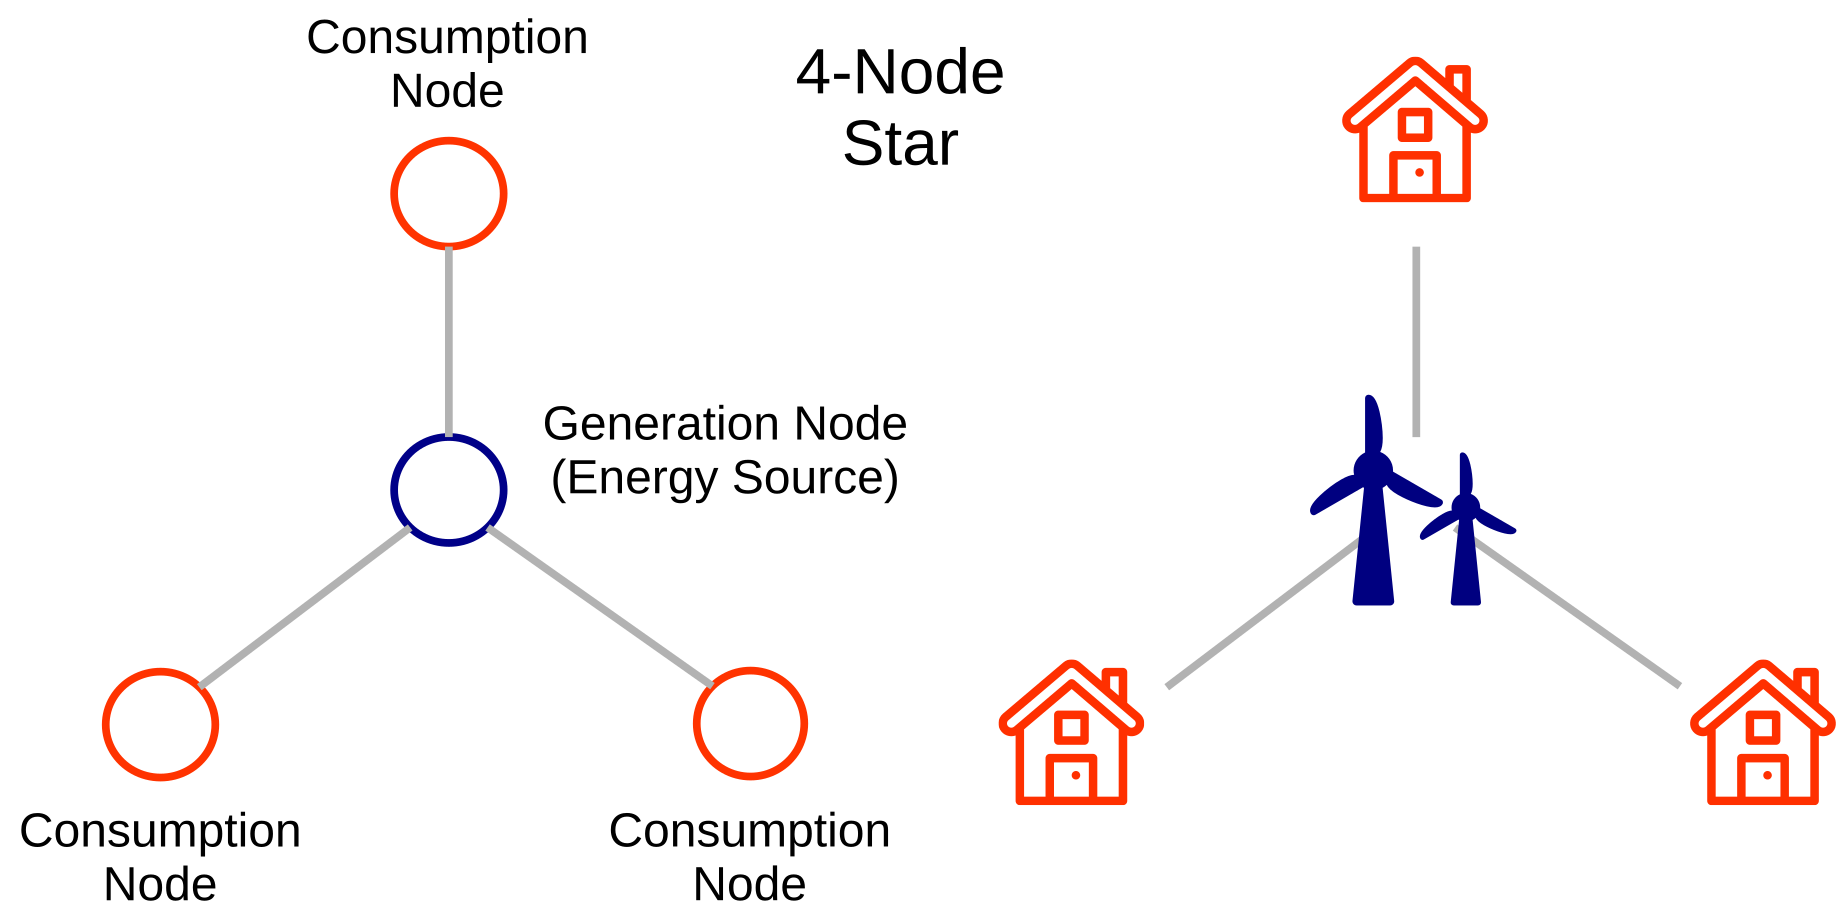
**Figure 1: 4-node star power grid model**

# 2 Data wrangling<a id='2_Data_wrangling'></a>

## 2.1 Data Collection<a id='2.2_Data Collection'></a>

Goal: Read the raw data and investigate the data structure of data frame.

### 2.1.1 Import the Libraries<a id='2.1.1_Import_the_Libraries'></a>

In [193]:
#Import pandas, matplotlib.pyplot, and seaborn, datetime below

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense

from datetime import datetime

In [194]:
import numpy as np
# scipi is a library for statistical tests and visualizations 
from scipy import stats

### 2.1.2 Load the Raw Data<a id='2.1.2_Load_the_Raw_Data'></a>

In [195]:
# load raw data from the project/data folder
df = pd.read_csv('../data/smart_grid_stability_augmented.csv')
df1 = pd.read_csv('../data/Data_for_UCI_named.csv')

### 2.1.3 Check the Raw Data<a id='2.1.3_Check_the_Raw_Data'></a>

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB


The format of df is good. There is no missing data for all columns. The column 13 is an object type, which indicates the stability factor (unstable or stable) of the power grid. It shall be converted as the binary values - 0 (unstable) and 1 (stable).

In [197]:
df.head(10)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
5,6.999209,9.109247,3.784066,4.267788,4.429669,-1.857139,-0.670397,-1.902133,0.261793,0.077930,0.542884,0.469931,-0.017385,stable
6,6.710166,3.765204,6.929314,8.818562,2.397419,-0.614590,-1.208826,-0.574004,0.177890,0.397977,0.402046,0.376630,0.005954,unstable
7,6.953512,1.379125,5.719400,7.870307,3.224495,-0.748998,-1.186517,-1.288980,0.371385,0.633204,0.732741,0.380544,0.016634,unstable
8,4.689852,4.007747,1.478573,3.733787,4.041300,-1.410344,-1.238204,-1.392751,0.269708,0.250364,0.164941,0.482439,-0.038677,stable
9,9.841496,1.413822,9.769856,7.641616,4.727595,-1.991363,-0.857637,-1.878594,0.376356,0.544415,0.792039,0.116263,0.012383,unstable


In [198]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


There are 12 predictive features:

'tau1' to 'tau4': the reaction time of each network participant. It is a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes) from the results of df.describe() above. 

'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4).

'g1' to 'g4': price elasticity coefficient for each network participant. It is a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma') from the results of df.describe() above. As defined in [1], gamma = c_1 dot c_2

\begin{equation*}
p_i(\frac{d\theta_i}{dt}) = p_\omega - c_1 \frac{d\theta_i}{dt}
\quad\quad  \text i={1,...,N}.     \quad\quad\quad\quad\quad\quad (1)
\end{equation*}

\begin{equation*}
\hat{P}_i(t) ≈ P_i + c_2 (p_i - P_\Omega)
\quad\quad  \text i={1,...,N}.     \quad\quad\quad\quad\quad\quad (2)
\end{equation*}

\begin{equation*}
\hat{P}_i(t) = P_i - \gamma_i \frac{d\theta_i}{dt}(t)
\quad\quad  \text i={1,...,N}.     \quad\quad\quad\quad\quad\quad (3)
\end{equation*}

where γi is proportional to the price elasticity of each node i, i.e., measures how much a producer or consumer is willing to adapt their consumption or production. In general, such an adaptation will not be instantaneous but will be delayed by a certain time τ by a measurement and the following reaction.

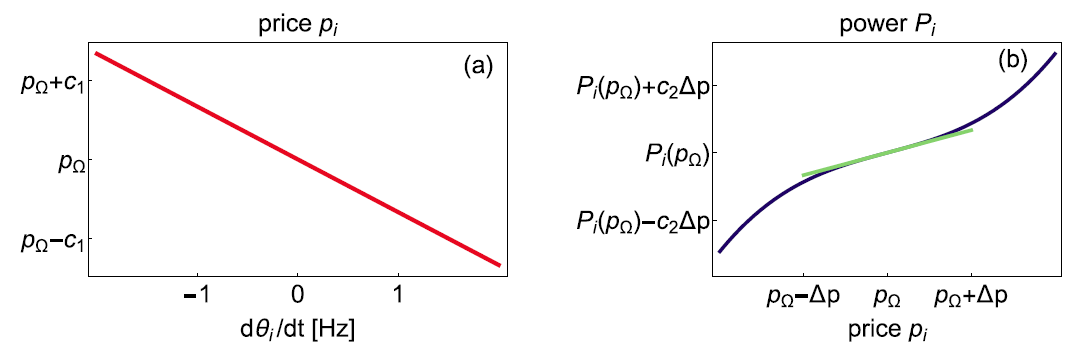
**Figure 2: Using linear relations the power becomes a linear function of the frequency deviation dθi/dt.** (a) We assume a linear price-frequency relation to motivate consumers to stabilize the grid. For example, if the production is larger than consumption, the power grid frequency increases. Hence, decreasing prices should motivate additional consumption. (b) Although consumers might react non-linearly towards price-changes (dark blue), we assume a linear relationship (light green) close to the operational frequency Ω which corresponds to dθi/dt = 0.

There are two dependent variables:

'stab': the maximum real part of the characteristic differentia equation root (if positive, the system is linearly unstable; if negative, linearly stable);

'stabf': a categorical (binary) label ('stable' or 'unstable').

As there is a direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' will be dropped and 'stabf' will remain as the sole dependent variable.

## 2.2 Data Definition<a id='2.2_Data_Definition'></a>

Goal: Gain an understanding of your data features to inform the next steps of EDA.

### 2.2.1 Clean the dataframe <a id='2.2.1_clean the dataframe'></a>

As the dataset content comes from simulation exercises, there are no missing values. Also, all features are originally numerical, no feature coding is required. Such dataset properties allow for a direct jump to machine modeling without the need of data preprocessing or feature engineering.

In [199]:

# replace the 'unstable' with '0' and 'stable' with '1' for column stabf
map1 = {'unstable': 0, 'stable': 1}
df['stabf'] = df['stabf'].replace(map1)
df1['stabf'] = df1['stabf'].replace(map1)

# shuffle the data
df = df.sample(frac=1)
df1 = df1.sample(frac=1)

### 2.2.2 Variable distribution <a id='2.2.2_Variable distribution'></a>

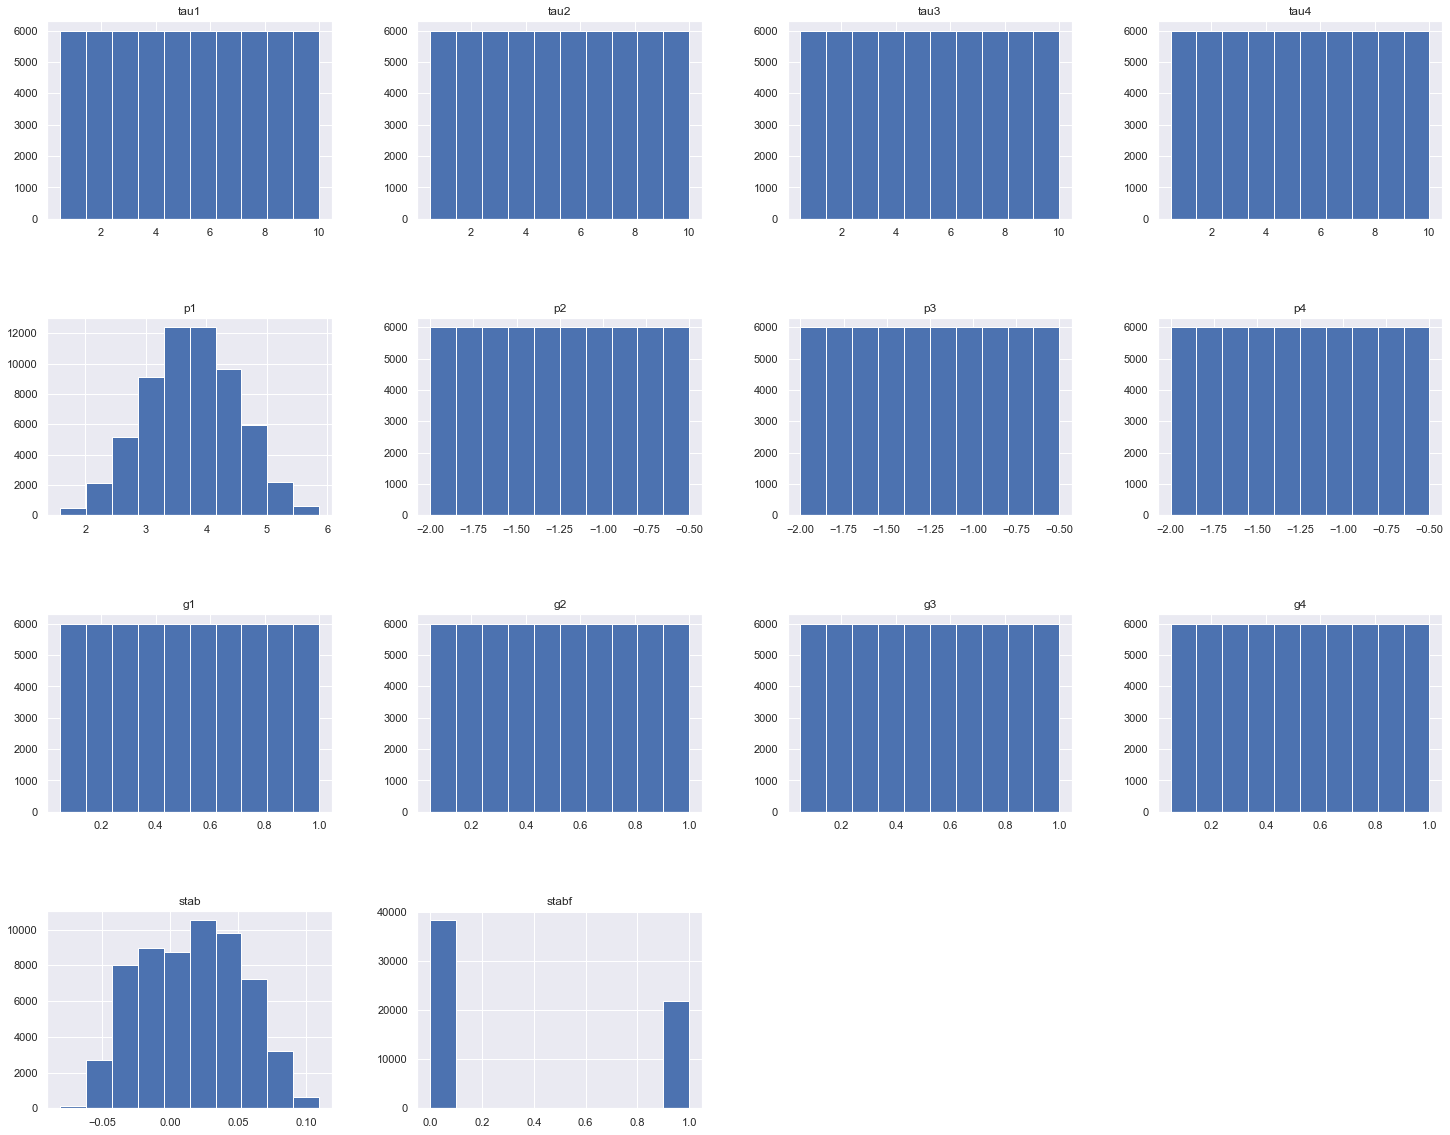

In [200]:
# plot the histgrams for each variable (12 predictive features and 2 dependent variables) to look at the distribution 
df.hist(figsize=(25,20))
plt.subplots_adjust(hspace=0.5);

Let us briefly look at the distribution of these variables.

tau1, tau2, tau3 and tau4: the reaction time of each network participant. They are even distribution from 0.5 to 10 and each data bin (0-1, 1-2, etc.) has about 6000 samples for each variables.

p2, p3, and p4: nominal power consumed (negative) by each network participant. They are also even distribution from -2.0 to -0.5.

p1: nominal power produced (positive). p1=-(p2+p3+p4). It is approximately a normal distribution, which is able to be proved by the Central Limit Theorem. The mean is 3.75 and the standard deviation is 0.752. 

g1, g2, g3 and g4: price elasticity coefficient for each network participant. They are even distribution from 0 to 1 to impact the electricity price as Figure 2(a) and (b).

stab:the maximum real part of the characteristic differentia equation root. If stab < 0, the grid is stable and stabf = "stable". If stab >= 0, the grid is unstable and stabf = "unstable". The range of stab is between -0.05 and 0.10.

stabf:a categorical (binary) label ('stable' or 'unstable'). The binary label (stabf = 0 means "unstable" and stabf = 1 means "stable". From the plots above, there are 40,000 unstable cases (stabf = 0), almost twice than the stable cases.

In [201]:
# save the data for future use
df.to_csv('../data/df_clean.csv')
df1.to_csv('../data/df1_clean.csv')

# 3 Exploratory Data Analysis<a id='3_Exploratory Data Analysis'></a>


## 3.1 Inferential Statistics

### 3.1.1 Overview of the dataset

In [202]:
# strip the column names to get rid of any pre and post white spaces
stripped_name = [col.strip() for col in list(df.columns)]
df.rename(columns=dict(zip(list(df.columns), stripped_name)), inplace=True)

In [203]:
# look at the columns of df
df.columns

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'stabf'],
      dtype='object')

In [204]:
# verify the data type and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 3609 to 34361
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 6.9 MB


Column "stabf" has been changed to int64 type with 0 and 1 to indicate "unstable" and "stable" cases. Other variables are float64 type data. There is no missing values in the dataset and all data are numeric type of data.

### 3.1.2 Cleaning, transforming and visualizing

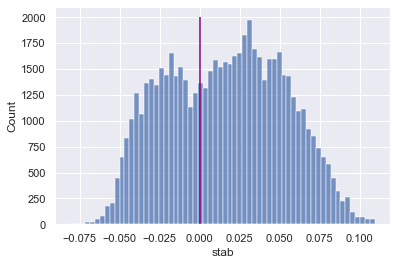

In [205]:
# Data are clean and concise. Plot the counts of "stab" cases
sns.histplot(data=df['stab']);
plt.vlines(x = 0, ymin = 0, ymax = 2000,
           colors = 'purple',
           label = 'Border of stable/unstable')
plt.show()

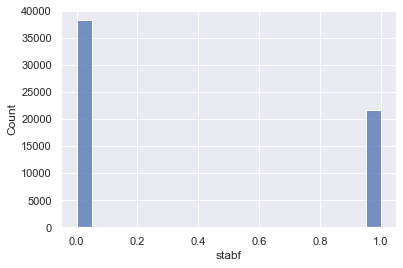

In [206]:
# Data are clean and concise. Plot the counts of unstable ans stable cases
sns.histplot(data=df['stabf']);

In [207]:
# To summarize analytically, let's use the groupby() method on our df.
df.groupby(by = 'stabf').mean()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
stabf,,,,,,,,,,,,,
0,5.735239,5.747946,5.747946,5.747946,3.755630,-1.251877,-1.251877,-1.251877,0.565832,0.570037,0.570037,0.570037,0.038727
1,4.394799,4.372406,4.372406,4.372406,3.740077,-1.246692,-1.246692,-1.246692,0.453035,0.445627,0.445627,0.445627,-0.024798


From the table above, we can see that tau1, tau2, tau3, tau4 and g1, g2, g3, g4 are siginificantly different for the unstable (stabf=0) and stable (stabf=1) cases. We also see slight differences of p1, p2, p3, p4 in unstable (stabf=0) and stable (stabf=1) cases.

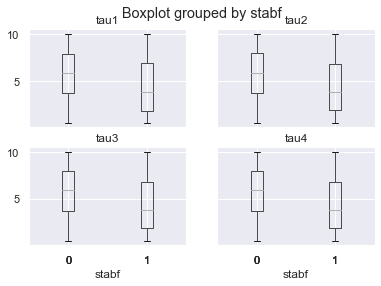

In [208]:
# Call the boxplot() method on our df based on tau.
df.boxplot(by = 'stabf', column = ['tau1', 'tau2', 'tau3', 'tau4']);

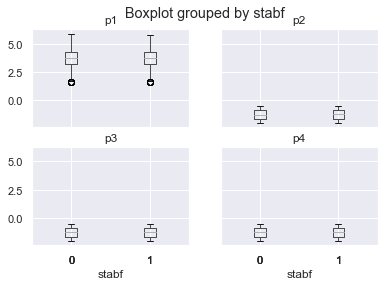

In [209]:
# Call the boxplot() method on our df based on p.
df.boxplot(by = 'stabf', column = ['p1', 'p2', 'p3', 'p4']);

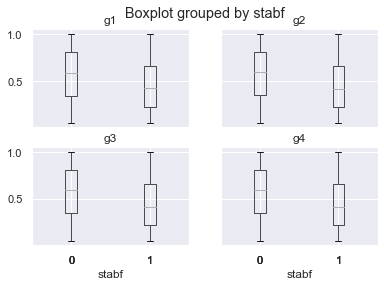

In [210]:
# Call the boxplot() method on our df based on g.
df.boxplot(by = 'stabf', column = ['g1', 'g2', 'g3', 'g4']);

From the first boxplot grouped by stabf for tau1, tau2, tau3 and tau4, the mean and the range (25%, 75%) of tau (reaction time) in unstable cases are significantly higher than those in the stable cases. There are the same trend for g1, g2, g3 and g4 about the price impacts.

The normal power produced (p1) and the normal power consumed (p2, p3, p4) are not significantly different between the unstable and stable cases. 

The impacts of these feature variables will be proved by hythesis analysis in the next section.

# 3.2 Hypothesis Tests <a id='3.2_hypothesis tests'></a>

## 3.2.1 Null hypothesis of tau_i

**Hypothesis formulation** <br>

Our Null hypothesis is:

H_null: the observed difference in the mean of tau_i (i=1,2,3,4) between the unstable cases and the stable cases is due to chance. That is, 

tau_i_u = tau_i_s

The alternate hypothesis:

H_alternative: there are significant difference (over the significance level 95%) between tau_i (i=1,2,3,4) in the unstable cases and the stable cases. That is,

tau_i_u ≠ tau_i_s

**Distribution of the data**

Now that the hypotheses and significance level are defined, we can select a statistical test to determine which hypothesis to accept.

There are many different statistical tests, all with different assumptions. But in general, one of the most important things to determine is the distribution of the data.

In [211]:
# Create a subset of the column 'tau1, tau2, tau3, tau4' by the different cases (unstable vs stable).

unstable_tau = df[df['stabf'] == 0][['tau1', 'tau2', 'tau3', 'tau4']]
stable_tau = df[df['stabf'] == 1][['tau1', 'tau2', 'tau3', 'tau4']]

In [212]:
# Using the stats.normaltest() method, get an indication of whether the data are normally distributed
# Save the result in a variable called unstable_tau_normal, and print it out
unstable_tau_normal = stats.normaltest(unstable_tau)
print(unstable_tau_normal)

NormaltestResult(statistic=array([ 9765.01017334, 10652.12523766, 10652.12523766, 10652.12523766]), pvalue=array([0., 0., 0., 0.]))


In [213]:
# Do the same with the stable_tau data. 
stable_tau_normal = stats.normaltest(stable_tau)
print(stable_tau_normal)

NormaltestResult(statistic=array([14353.89894494,  9941.72990696,  9941.72990696,  9941.72990696]), pvalue=array([0., 0., 0., 0.]))


Since the null hypothesis of the normaltest() is that the data are normally distributed, the lower the p-value in the result of this test, the more likely the data are to be non-normal.

Since the p-values is 0 for both tests, regardless of what we pick for the significance level, our conclusion is that the data are not normally distributed.

We can actually also check out the distribution of the data visually with a histogram. A normal distribution has the following visual characteristics: - symmetric - unimodal (one hump) As well as a roughly identical mean, median and mode.

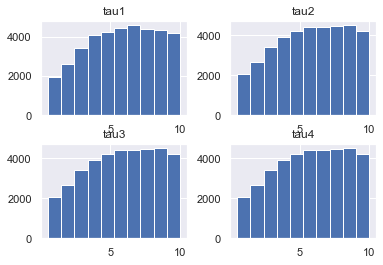

In [214]:
# Create a histogram of the unstable_tau reviews distribution
unstable_tau.hist();

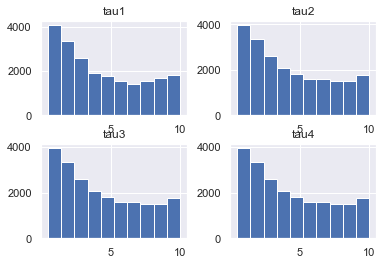

In [215]:
# Create a histogram of the google data
stable_tau.hist();

**Permutation test** <br>

Since the data aren't normally distributed, we're using a non-parametric test here. This is simply a label for statistical tests used when the data aren't normally distributed. These tests are extraordinarily powerful due to how few assumptions we need to make.

- summaries of permutation distributions for tau_i under unstable and stable cases

In [216]:
# Create a column called `Permutation_tau1`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_tau1'] = np.random.permutation(df.loc[:,'tau1'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_tau1'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,5.241912,2.741260,0.500793,2.862954,5.246756,7.615482,9.999469
1,21720.0,5.264254,2.744507,0.500793,2.890254,5.256183,7.639495,9.999469


In [217]:
# Create a column called `Permutation_tau2`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_tau2'] = np.random.permutation(df.loc[:,'tau2'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_tau2'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,5.247333,2.742443,0.500141,2.872212,5.235460,7.625514,9.999837
1,21720.0,5.254702,2.742483,0.500788,2.879849,5.271288,7.624739,9.999837


In [218]:
# Create a column called `Permutation_tau3`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_tau3'] = np.random.permutation(df.loc[:,'tau3'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_tau3'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,5.252592,2.737558,0.500141,2.894125,5.246062,7.615943,9.999837
1,21720.0,5.245434,2.751071,0.500141,2.847694,5.256418,7.643821,9.998912


In [219]:
# Create a column called `Permutation_tau4`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_tau4'] = np.random.permutation(df.loc[:,'tau4'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_tau4'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,5.25231,2.741130,0.500141,2.885708,5.249761,7.627359,9.999837
1,21720.0,5.24593,2.744797,0.500473,2.856282,5.250070,7.620590,9.999837


- summaries of distributions for tau_i under unstable and stable cases

In [220]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['tau1'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,5.735239,2.530923,0.501331,3.722817,5.848943,7.863300,9.999469
1,21720.0,4.394799,2.888028,0.500793,1.804331,3.758877,6.900402,9.995375


In [221]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['tau2'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,5.747946,2.551192,0.503084,3.718885,5.874826,7.919592,9.999450
1,21720.0,4.372406,2.845764,0.500141,1.842559,3.764308,6.740758,9.999837


In [222]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['tau3'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,5.747946,2.551192,0.503084,3.718885,5.874826,7.919592,9.999450
1,21720.0,4.372406,2.845764,0.500141,1.842559,3.764308,6.740758,9.999837


In [223]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['tau4'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,5.747946,2.551192,0.503084,3.718885,5.874826,7.919592,9.999450
1,21720.0,4.372406,2.845764,0.500141,1.842559,3.764308,6.740758,9.999837


**Calculate the p-value to do the hypothesis test**

In [224]:
# The difference in the means for Permutation1 (0.0000625) now looks hugely different to our observed difference of 0.066546. 
# It's sure starting to look like our observed difference is significant, and that the Null is false; the fault (oatplus2) does impact on OA damper position
# But to be sure, let's create 10,000 permutations, calculate the mean ratings for normal1 and fault1 and the difference between these for each one, and then take the average of all of these differences.
# Let's create a vector with the differences - that will be the distibution of the Null.

# First, make a list called difference.
difference_tau1 =[]

# Now make a for loop that does the following 10,000 times:
# 1. makes a permutation of the 'Rating' as you did above
# 2. calculates the difference in the mean rating for apple and the mean rating for google. 
for i in range(10000):
    permutation = np.random.permutation(df.loc[:,'tau1'])
    difference_tau1.append(np.mean(permutation[df['stabf'] == 0]) - np.mean(permutation[df['stabf'] == 1]))

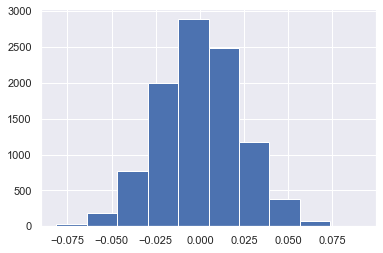

In [225]:
# Make a variable called 'histo', and assign to it the result of plotting a histogram of the difference list. 
histo_tau1 = plt.hist(difference_tau1)

In [226]:
# Now make a variable called obs_difference_tau1, and assign it the result of the mean of our 'normal1' variable and the mean of our 'fault1' variable
obs_difference_tau1 = np.mean(df[df['stabf'] == 0]['tau1']) - np.mean(df[df['stabf'] == 1]['tau1'])

# Make this difference absolute with the built-in abs() function. 
obs_difference_tau1 = abs(obs_difference_tau1)

# Print out this value; it should be 0.09169. 
print(obs_difference_tau1)

1.34043961778998


In [227]:
'''
What do we know? 
Recall: The p-value of our observed data is just the proportion of the data given the null that's at least as extreme as that observed data.
As a result, we're going to count how many of the differences in our difference list are at least as extreme as our observed difference.
If less than or equal to 5% of them are, then we will reject the Null. 
'''
# check how many of the differences are at least as extreme as (95%) our observed differenc
sum([(diff - obs_difference_tau1) > 0 for diff in difference_tau1]) / len(difference_tau1)

0.0

So actually, zero differences are at least as extreme as our observed difference!
So the p-value of our observed data is 0.
It doesn't matter which significance level we pick; our observed data is statistically significant, and we reject the **H<sub>Null</sub>** and accept **H<sub>Alternatative</sub>**.

In [228]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf,Permutation_tau1,Permutation_tau2,Permutation_tau3,Permutation_tau4
3609,8.645309,3.256028,8.036338,0.574878,4.575569,-1.504505,-1.212604,-1.858460,0.132329,0.483206,0.770303,0.481933,-0.016740,1,3.875334,0.820400,9.779785,0.812427
32826,9.725355,9.725430,1.986918,9.289480,3.117742,-0.839700,-1.048309,-1.229734,0.840022,0.495160,0.425477,0.169831,0.031697,0,0.797426,7.483494,4.032688,9.733149
21891,2.734846,2.702091,5.643794,6.893314,3.674487,-1.379123,-0.750157,-1.545207,0.769622,0.120559,0.461802,0.081015,-0.036331,1,3.992457,0.839464,4.072415,2.448858
10606,5.591436,2.432085,2.228570,9.077714,4.820076,-1.694155,-1.798922,-1.327000,0.194982,0.119791,0.771197,0.238160,-0.015882,1,2.281773,6.731092,9.334858,9.873543
5597,5.721284,7.890108,8.694785,4.177385,2.823422,-1.113035,-1.068521,-0.641865,0.854674,0.687525,0.984706,0.886792,0.095532,0,6.533349,3.652554,9.647606,3.142916


In [229]:
df.drop(["Permutation_tau1", "Permutation_tau2", "Permutation_tau3", "Permutation_tau4"], axis = 1, inplace=True)

## 3.2.2 Null hypothesis of g_i

**Hypothesis formulation** <br>

Our Null hypothesis is:

H_null: the observed difference in the mean of g_i (i=1,2,3,4) between the unstable cases and the stable cases is due to chance. That is, 

g_i_u = g_i_s

The alternate hypothesis:

H_alternative: there are significant difference (over the significance level 95%) between g_i (i=1,2,3,4) in the unstable cases and the stable cases. That is,

g_i_u ≠ g_i_s

**Distribution of the data**

Now that the hypotheses and significance level are defined, we can select a statistical test to determine which hypothesis to accept.

There are many different statistical tests, all with different assumptions. But in general, one of the most important things to determine is the distribution of the data.

In [230]:
# Create a subset of the column 'g1, g2, g3, g4' by the different cases (unstable vs stable).

unstable_g = df[df['stabf'] == 0][['g1', 'g2', 'g3', 'g4']]
stable_g = df[df['stabf'] == 1][['g1', 'g2', 'g3', 'g4']]

In [231]:
# Using the stats.normaltest() method, get an indication of whether the data are normally distributed
# Save the result in a variable called unstable_tau_normal, and print it out
unstable_g_normal = stats.normaltest(unstable_g)
print(unstable_g_normal)

NormaltestResult(statistic=array([22009.88490859, 19229.82027463, 19229.82027463, 19229.82027463]), pvalue=array([0., 0., 0., 0.]))


In [232]:
# Do the same with the stable_tau data. 
stable_g_normal = stats.normaltest(stable_g)
print(stable_g_normal)

NormaltestResult(statistic=array([6077.17834241, 5548.99328209, 5548.99328209, 5548.99328209]), pvalue=array([0., 0., 0., 0.]))


Since the null hypothesis of the normaltest() is that the data are normally distributed, the lower the p-value in the result of this test, the more likely the data are to be non-normal.

Since the p-values is 0 for both tests, regardless of what we pick for the significance level, our conclusion is that the data are not normally distributed.

We can actually also check out the distribution of the data visually with a histogram. A normal distribution has the following visual characteristics: - symmetric - unimodal (one hump) As well as a roughly identical mean, median and mode.

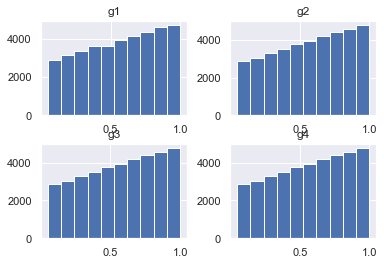

In [233]:
# Create a histogram of the unstable_g reviews distribution
unstable_g.hist();

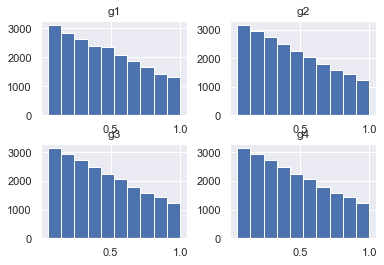

In [234]:
# Create a histogram of the stable_g data
stable_g.hist();

**Permutation test** <br>

Since the data aren't normally distributed, we're using a non-parametric test here. This is simply a label for statistical tests used when the data aren't normally distributed. These tests are extraordinarily powerful due to how few assumptions we need to make.

- summaries of permutation distributions for g_i under unstable and stable cases

In [235]:
# Create a column called `Permutation_g1`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_g1'] = np.random.permutation(df.loc[:,'g1'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_g1'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,0.524061,0.274171,0.050009,0.286308,0.523192,0.761753,0.999937
1,21720.0,0.526654,0.274372,0.050212,0.289595,0.528928,0.763631,0.999937


In [236]:
# Create a column called `Permutation_g2`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_g2'] = np.random.permutation(df.loc[:,'g2'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_g2'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,0.526164,0.274371,0.050028,0.288990,0.526842,0.763629,0.999982
1,21720.0,0.522949,0.274013,0.050028,0.285051,0.521907,0.760118,0.999982


In [237]:
# Create a column called `Permutation_g3`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_g3'] = np.random.permutation(df.loc[:,'g3'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_g3'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,0.525588,0.273658,0.050028,0.289278,0.526305,0.762382,0.999982
1,21720.0,0.523965,0.275275,0.050028,0.284145,0.522900,0.762611,0.999982


In [238]:
# Create a column called `Permutation_g4`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_g4'] = np.random.permutation(df.loc[:,'g4'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_g4'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,0.524804,0.273803,0.050028,0.288084,0.52361,0.762503,0.999982
1,21720.0,0.525347,0.275024,0.050054,0.286169,0.52774,0.762411,0.999944


- summaries of distributions for g_i under unstable and stable cases

In [239]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['g1'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,0.565832,0.270849,0.050009,0.339685,0.586484,0.802945,0.999937
1,21720.0,0.453035,0.265249,0.050184,0.222476,0.425106,0.659667,0.999628


In [240]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['g2'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,0.570037,0.269807,0.050054,0.346197,0.590840,0.804580,0.999982
1,21720.0,0.445627,0.263803,0.050028,0.216410,0.410625,0.652281,0.999893


In [241]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['g3'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,0.570037,0.269807,0.050054,0.346197,0.590840,0.804580,0.999982
1,21720.0,0.445627,0.263803,0.050028,0.216410,0.410625,0.652281,0.999893


In [242]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['g4'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,0.570037,0.269807,0.050054,0.346197,0.590840,0.804580,0.999982
1,21720.0,0.445627,0.263803,0.050028,0.216410,0.410625,0.652281,0.999893


**Calculate the p-value to do the hypothesis test**

In [243]:
# The difference in the means for Permutation1 (0.0000625) now looks hugely different to our observed difference of 0.066546. 
# It's sure starting to look like our observed difference is significant, and that the Null is false; the fault (oatplus2) does impact on OA damper position
# But to be sure, let's create 10,000 permutations, calculate the mean ratings for normal1 and fault1 and the difference between these for each one, and then take the average of all of these differences.
# Let's create a vector with the differences - that will be the distibution of the Null.

# First, make a list called difference.
difference_g1 =[]

# Now make a for loop that does the following 10,000 times:
# 1. makes a permutation of the 'Rating' as you did above
# 2. calculates the difference in the mean rating for apple and the mean rating for google. 
for i in range(10000):
    permutation = np.random.permutation(df.loc[:,'g1'])
    difference_g1.append(np.mean(permutation[df['stabf'] == 0]) - np.mean(permutation[df['stabf'] == 1]))

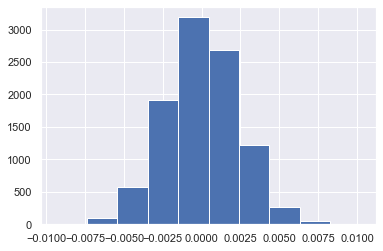

In [244]:
# Make a variable called 'histo', and assign to it the result of plotting a histogram of the difference list. 
histo_g1 = plt.hist(difference_g1)

In [245]:
# Now make a variable called obs_difference_g1, and assign it the result of the mean of our 'normal1' variable and the mean of our 'fault1' variable
obs_difference_g1 = np.mean(df[df['stabf'] == 0]['g1']) - np.mean(df[df['stabf'] == 1]['g1'])

# Make this difference absolute with the built-in abs() function. 
obs_difference_g1 = abs(obs_difference_g1)

# Print out this value; it should be 0.09169. 
print(obs_difference_g1)

0.11279697217235263


In [246]:
'''
What do we know? 
Recall: The p-value of our observed data is just the proportion of the data given the null that's at least as extreme as that observed data.
As a result, we're going to count how many of the differences in our difference list are at least as extreme as our observed difference.
If less than or equal to 5% of them are, then we will reject the Null. 
'''
# check how many of the differences are at least as extreme as (95%) our observed differenc
sum([(diff - obs_difference_g1) > 0 for diff in difference_g1]) / len(difference_g1)

0.0

So actually, zero differences are at least as extreme as our observed difference!
So the p-value of our observed data is 0.
It doesn't matter which significance level we pick; our observed data is statistically significant, and we reject the **H<sub>Null</sub>** and accept **H<sub>Alternatative</sub>**.

In [247]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf,Permutation_g1,Permutation_g2,Permutation_g3,Permutation_g4
3609,8.645309,3.256028,8.036338,0.574878,4.575569,-1.504505,-1.212604,-1.858460,0.132329,0.483206,0.770303,0.481933,-0.016740,1,0.918667,0.923861,0.385971,0.233816
32826,9.725355,9.725430,1.986918,9.289480,3.117742,-0.839700,-1.048309,-1.229734,0.840022,0.495160,0.425477,0.169831,0.031697,0,0.809012,0.950725,0.338843,0.631929
21891,2.734846,2.702091,5.643794,6.893314,3.674487,-1.379123,-0.750157,-1.545207,0.769622,0.120559,0.461802,0.081015,-0.036331,1,0.791028,0.635094,0.809798,0.125306
10606,5.591436,2.432085,2.228570,9.077714,4.820076,-1.694155,-1.798922,-1.327000,0.194982,0.119791,0.771197,0.238160,-0.015882,1,0.120743,0.309969,0.137081,0.582975
5597,5.721284,7.890108,8.694785,4.177385,2.823422,-1.113035,-1.068521,-0.641865,0.854674,0.687525,0.984706,0.886792,0.095532,0,0.391052,0.433057,0.683394,0.631088


In [248]:
df.drop(["Permutation_g1", "Permutation_g2", "Permutation_g3", "Permutation_g4"], axis = 1, inplace=True)

## 3.2.3 Null hypothesis of p_i

**Hypothesis formulation** <br>

Our Null hypothesis is:

H_null: the observed difference in the mean of p_i (i=1,2,3,4) between the unstable cases and the stable cases is due to chance. That is, 

p_i_u = p_i_s

The alternate hypothesis:

H_alternative: there are significant difference (over the significance level 95%) between p_i (i=1,2,3,4) in the unstable cases and the stable cases. That is,

p_i_u ≠ p_i_s

**Distribution of the data**

Now that the hypotheses and significance level are defined, we can select a statistical test to determine which hypothesis to accept.

There are many different statistical tests, all with different assumptions. But in general, one of the most important things to determine is the distribution of the data.

In [249]:
# Create a subset of the column 'p1, p2, p3, p4' by the different cases (unstable vs stable).

unstable_p = df[df['stabf'] == 0][['p1', 'p2', 'p3', 'p4']]
stable_p = df[df['stabf'] == 1][['p1', 'p2', 'p3', 'p4']]

In [250]:
# Using the stats.normaltest() method, get an indication of whether the data are normally distributed
# Save the result in a variable called unstable_tau_normal, and print it out
unstable_p_normal = stats.normaltest(unstable_p)
print(unstable_p_normal)

NormaltestResult(statistic=array([  460.65823381, 32496.15708191, 32496.15708191, 32496.15708191]), pvalue=array([9.31827463e-101, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))


In [251]:
# Do the same with the stable_p data. 
stable_p_normal = stats.normaltest(stable_p)
print(stable_p_normal)

NormaltestResult(statistic=array([  148.69175556, 20617.04621868, 20617.04621868, 20617.04621868]), pvalue=array([5.15223338e-33, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))


Since the null hypothesis of the normaltest() is that the data are normally distributed, the lower the p-value in the result of this test, the more likely the data are to be non-normal.

Since the p-values is 0 for both tests, regardless of what we pick for the significance level, our conclusion is that the data are not normally distributed.

We can actually also check out the distribution of the data visually with a histogram. A normal distribution has the following visual characteristics: - symmetric - unimodal (one hump) As well as a roughly identical mean, median and mode.

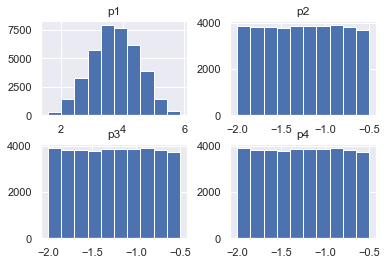

In [252]:
# Create a histogram of the unstable_p reviews distribution
unstable_p.hist();

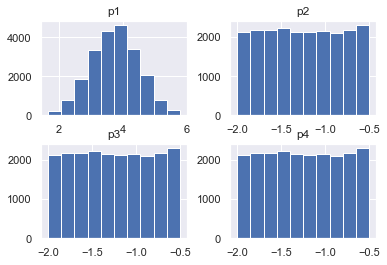

In [253]:
# Create a histogram of the stable_p data
stable_p.hist();

**Permutation test** <br>

Since the data aren't normally distributed, we're using a non-parametric test here. This is simply a label for statistical tests used when the data aren't normally distributed. These tests are extraordinarily powerful due to how few assumptions we need to make.

- summaries of permutation distributions for g_i under unstable and stable cases

In [254]:
# Create a column called `Permutation_p1`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_p1'] = np.random.permutation(df.loc[:,'p1'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_p1'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,3.749360,0.752314,1.58259,3.215872,3.752202,4.283281,5.864418
1,21720.0,3.751127,0.751817,1.58259,3.221805,3.749337,4.281664,5.864418


In [255]:
# Create a column called `Permutation_p2`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_p2'] = np.random.permutation(df.loc[:,'p2'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_p2'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,-1.250081,0.432810,-1.999945,-1.626675,-1.249159,-0.875096,-0.500025
1,21720.0,-1.249857,0.433391,-1.999926,-1.622272,-1.251553,-0.874687,-0.500072


In [256]:
# Create a column called `Permutation_p3`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_p3'] = np.random.permutation(df.loc[:,'p3'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_p3'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,-1.247516,0.432739,-1.999945,-1.620424,-1.247619,-0.873368,-0.500025
1,21720.0,-1.254379,0.433482,-1.999945,-1.632830,-1.254321,-0.877994,-0.500108


In [257]:
# Create a column called `Permutation_p4`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df['Permutation_p4'] = np.random.permutation(df.loc[:,'p4'])

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('stabf')['Permutation_p4'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,-1.249947,0.432386,-1.999945,-1.624085,-1.247987,-0.875848,-0.500025
1,21720.0,-1.250093,0.434136,-1.999945,-1.626584,-1.253592,-0.873807,-0.500025


- summaries of distributions for p_i under unstable and stable cases

In [258]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['p1'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,3.755630,0.756943,1.58259,3.219895,3.752572,4.296543,5.864418
1,21720.0,3.740077,0.743482,1.64286,3.215978,3.746810,4.258230,5.798273


In [259]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['p2'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,-1.251877,0.432238,-1.999926,-1.626265,-1.250292,-0.879786,-0.500025
1,21720.0,-1.246692,0.434377,-1.999945,-1.621942,-1.249281,-0.866687,-0.500198


In [260]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['p3'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,-1.251877,0.432238,-1.999926,-1.626265,-1.250292,-0.879786,-0.500025
1,21720.0,-1.246692,0.434377,-1.999945,-1.621942,-1.249281,-0.866687,-0.500198


In [261]:
# Lets compare with the previous analytical summary:
df.groupby('stabf')['p4'].describe()

,count,mean,std,min,25%,50%,75%,max
stabf,,,,,,,,
0,38280.0,-1.251877,0.432238,-1.999926,-1.626265,-1.250292,-0.879786,-0.500025
1,21720.0,-1.246692,0.434377,-1.999945,-1.621942,-1.249281,-0.866687,-0.500198


**Calculate the p-value to do the hypothesis test**

In [262]:
# The difference in the means for Permutation1 (0.0000625) now looks hugely different to our observed difference of 0.066546. 
# It's sure starting to look like our observed difference is significant, and that the Null is false; the fault (oatplus2) does impact on OA damper position
# But to be sure, let's create 10,000 permutations, calculate the mean ratings for normal1 and fault1 and the difference between these for each one, and then take the average of all of these differences.
# Let's create a vector with the differences - that will be the distibution of the Null.

# First, make a list called difference.
difference_p1 =[]

# Now make a for loop that does the following 10,000 times:
# 1. makes a permutation of the 'Rating' as you did above
# 2. calculates the difference in the mean rating for apple and the mean rating for google. 
for i in range(10000):
    permutation = np.random.permutation(df.loc[:,'p1'])
    difference_p1.append(np.mean(permutation[df['stabf'] == 0]) - np.mean(permutation[df['stabf'] == 1]))

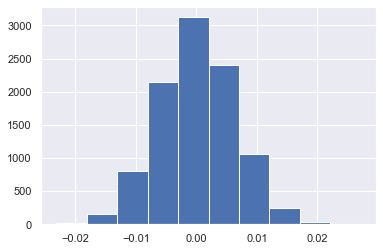

In [263]:
# Make a variable called 'histo', and assign to it the result of plotting a histogram of the difference list. 
histo_p1 = plt.hist(difference_p1)

In [264]:
# Now make a variable called obs_difference_p1, and assign it the result of the mean of our 'normal1' variable and the mean of our 'fault1' variable
obs_difference_p1 = np.mean(df[df['stabf'] == 0]['p1']) - np.mean(df[df['stabf'] == 1]['p1'])

# Make this difference absolute with the built-in abs() function. 
obs_difference_p1 = abs(obs_difference_p1)

# Print out this value; it should be 0.09169. 
print(obs_difference_p1)

0.015552732748832732


In [265]:
'''
What do we know? 
Recall: The p-value of our observed data is just the proportion of the data given the null that's at least as extreme as that observed data.
As a result, we're going to count how many of the differences in our difference list are at least as extreme as our observed difference.
If less than or equal to 5% of them are, then we will reject the Null. 
'''
# check how many of the differences are at least as extreme as (95%) our observed differenc
sum([(diff - obs_difference_p1) > 0 for diff in difference_p1]) / len(difference_p1)

0.0078

So actually, the difference percentage is 0.008, which are at least as extreme as our observed difference!
So the p-value of our observed data is 0.008, which is less than the significance level 0.05. Our observed data is still statistically significant, and we reject the **H<sub>Null</sub>** and accept **H<sub>Alternatative</sub>**.

In [266]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf,Permutation_p1,Permutation_p2,Permutation_p3,Permutation_p4
3609,8.645309,3.256028,8.036338,0.574878,4.575569,-1.504505,-1.212604,-1.858460,0.132329,0.483206,0.770303,0.481933,-0.016740,1,3.274218,-0.853039,-1.939888,-1.248933
32826,9.725355,9.725430,1.986918,9.289480,3.117742,-0.839700,-1.048309,-1.229734,0.840022,0.495160,0.425477,0.169831,0.031697,0,2.851991,-1.546159,-1.126048,-1.175681
21891,2.734846,2.702091,5.643794,6.893314,3.674487,-1.379123,-0.750157,-1.545207,0.769622,0.120559,0.461802,0.081015,-0.036331,1,3.374144,-1.178531,-0.787503,-0.693021
10606,5.591436,2.432085,2.228570,9.077714,4.820076,-1.694155,-1.798922,-1.327000,0.194982,0.119791,0.771197,0.238160,-0.015882,1,2.667648,-0.983100,-0.950919,-1.695775
5597,5.721284,7.890108,8.694785,4.177385,2.823422,-1.113035,-1.068521,-0.641865,0.854674,0.687525,0.984706,0.886792,0.095532,0,3.148000,-0.732142,-1.681205,-1.037053


In [267]:
df.drop(["Permutation_p1", "Permutation_p2", "Permutation_p3", "Permutation_p4"], axis = 1, inplace=True)

From the hypothesis tests above, we know that we reject the null hypothesis and accept the alternative hythesis. The feature variables, tau_i, g_i and p_i, impact the stability of the power grid, although the impact of p_i (normal power produced or consumed) is not as significant as tau_i (reaction time) and g_i (price elasticity coefficient). The correlation of these features with the stability of the power grid will be investigated in Chapter 4.

# 4 Pre-processing and Training Data<a id='04_Pre-processing and Training Data'></a>

## 4.1 Customized functions

Functions were developed to assist with graphical analysis of specific dataset elements (features or observations) and mapping correlation. Please refer to the respective docstrings below for details. Note that all function variable names, by coding principle, start with the "f_" string, allowing for containerized processing within the function execution environment, not affecting global variables.

def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.histplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)
    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()

    
def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=True, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

## 4.2 Correlation

It is important to verify the correlation between each numerical feature and the dependent variable, as well as correlation among numerical features leading to potential undesired colinearity. The heatmap below provides an overview of correlation between the dependent variable ('stabf') and the 12 numerical features. Note that also the alternative dependent variable ('stab') has been included just to give an idea of how correlated it is with 'stabf'. Such correlation is significant (-0.83), as it should be, which reinforces the decision to drop it, anticipated in Section 3. Also, correlation between 'p1' and its components 'p2', 'p3' and 'p4' is above average, as expected, but not as high o justify any removal.

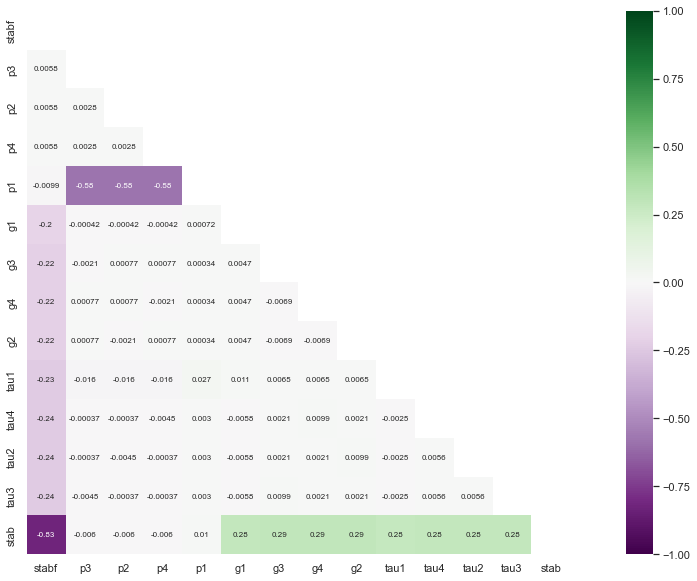

In [268]:
correlation_map(df, 'stabf', 14)

## 4.3 Segregating train and test sets

As anticipated, the features dataset will contain all 12 original predictive features, while the label dataset will contain only 'stabf' ('stab' is dropped here).

In addition, as the dataset has already been shuffled, the training set will receive the first 54,000 observations, while the testing set will accommodate the last 6,000.

Even considering that the dataset is large enough and well behaved, the percentage of 'stable' and 'unstable' observations is computed for both training and testing sets, just to make sure that the original dataset distribution is maintained after the split - which proved to be the case.

After splitting, Pandas dataframes and series are transformed into Numpy arrays for the remainder of the exercise.

In [269]:
X = df.iloc[:, :12]
y = df.iloc[:, 13]

X_training = X.iloc[:54000, :]
y_training = y.iloc[:54000]

X_testing = X.iloc[54000:, :]
y_testing = y.iloc[54000:]

ratio_training = y_training.value_counts(normalize=True)
ratio_testing = y_testing.value_counts(normalize=True)
ratio_training, ratio_testing

(0    0.638722
 1    0.361278
 Name: stabf, dtype: float64,
 0    0.6315
 1    0.3685
 Name: stabf, dtype: float64)

In [270]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

Splitting the original data 


In [271]:
df1.head(10)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
310,5.415594,7.328842,1.880599,2.711995,4.986599,-1.699342,-1.724267,-1.562991,0.676422,0.513419,0.692913,0.751074,0.024727,0
7683,9.768070,4.479498,3.771622,5.320862,2.326089,-1.102648,-0.600460,-0.622981,0.117811,0.106784,0.592584,0.058820,-0.047139,1
5058,2.079181,9.630668,3.308782,3.941799,3.600997,-1.318294,-1.196225,-1.086478,0.654963,0.778023,0.127205,0.393785,-0.012157,1
5618,2.753329,8.409062,9.535955,0.659880,3.212980,-1.543207,-0.983352,-0.686422,0.262925,0.516358,0.176910,0.586622,-0.047600,1
2265,1.328471,7.561307,4.753749,6.981377,4.768004,-1.558334,-1.805149,-1.404521,0.828858,0.412679,0.574556,0.210110,-0.015198,1
6148,1.838480,9.506150,5.621914,1.774866,2.139217,-0.519870,-0.524819,-1.094528,0.673181,0.380431,0.728950,0.544159,-0.023984,1
1281,4.800217,2.032820,6.904982,6.833015,4.766533,-1.946752,-1.357245,-1.462536,0.668713,0.439369,0.280033,0.272144,0.000756,0
6803,1.678805,4.252165,5.521380,5.139960,4.097010,-0.593874,-1.531084,-1.972052,0.594646,0.845712,0.768715,0.252917,0.043273,0
7842,6.087321,4.228622,8.933842,8.904292,3.418565,-0.994217,-0.773726,-1.650622,0.688292,0.070775,0.972428,0.813404,0.074620,0
5784,7.073383,6.114988,5.087622,7.905508,2.952279,-1.811267,-0.534097,-0.606915,0.682280,0.178332,0.639249,0.361490,0.045060,0


In [272]:
X1 = df1.iloc[:, :12]
y1 = df1.iloc[:, 13]

X1_training = X1.iloc[:9000, :]
y1_training = y1.iloc[:9000]

X1_testing = X1.iloc[9000:, :]
y1_testing = y1.iloc[9000:]

ratio_training_1 = y1_training.value_counts(normalize=True)
ratio_testing_1 = y1_testing.value_counts(normalize=True)
ratio_training_1, ratio_testing_1

(0    0.636556
 1    0.363444
 Name: stabf, dtype: float64,
 0    0.651
 1    0.349
 Name: stabf, dtype: float64)

In [273]:
X1_training = X1_training.values
y1_training = y1_training.values

X1_testing = X1_testing.values
y1_testing = y1_testing.values

## 4.4 Feature assessing and scaling

Distribution patterns and the relationship with the 'stab' dependent variable is charted for each of the 12 dataset features.

As this data comes from simulations with predetermined fixed ranges for all features, as described in Section 3, distributions are pretty much uniform across the board, with the exception of 'p1' (absolute sum of 'p2', 'p3' and 'p4'), which follows a normal distribution (as expected) with a very small skew factor of -0.013.

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


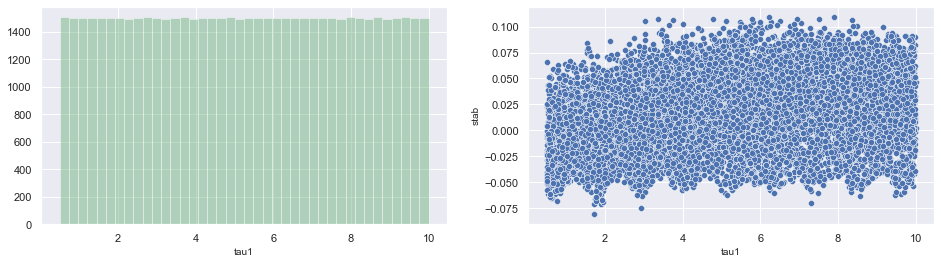

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


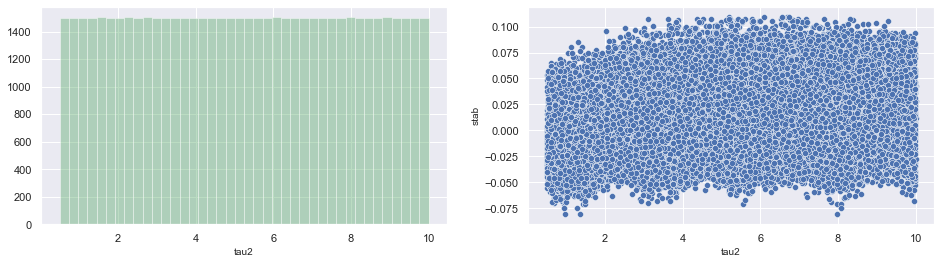

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


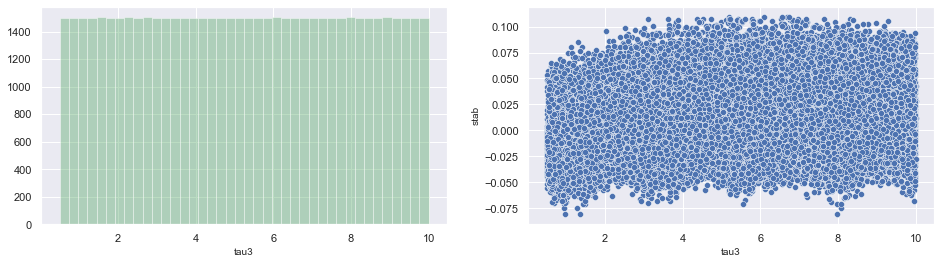

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


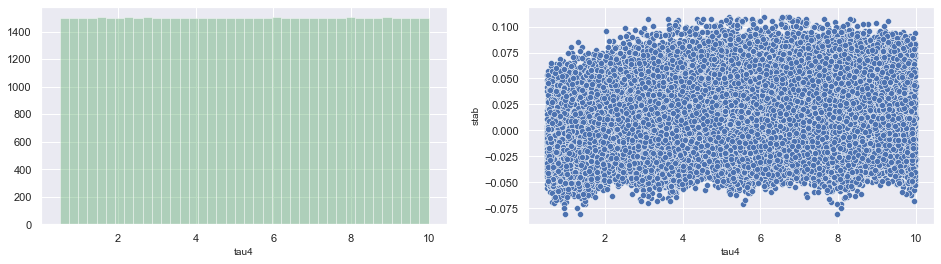

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


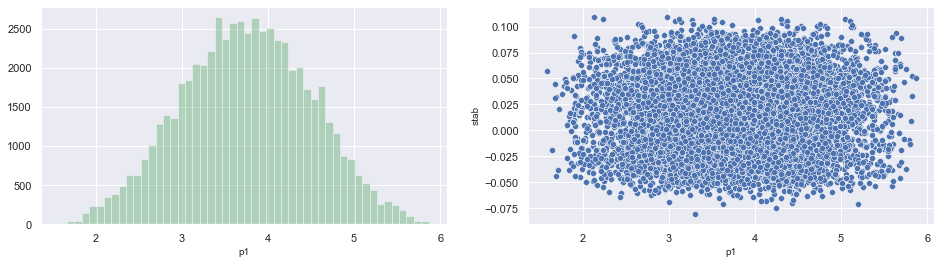

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


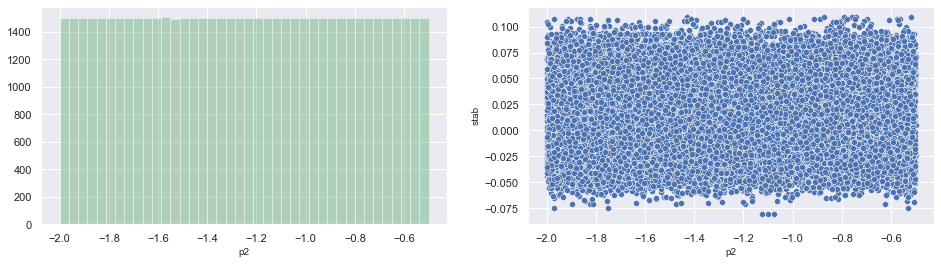

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


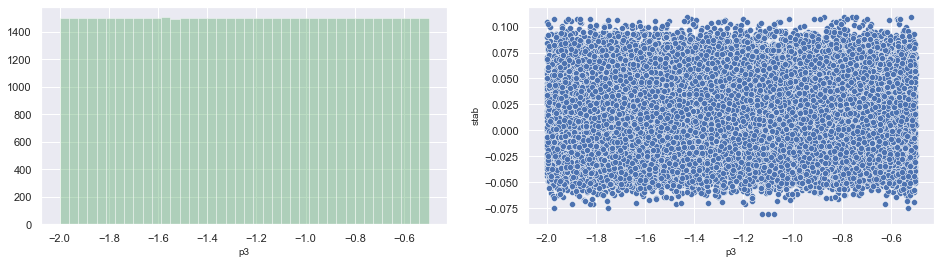

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


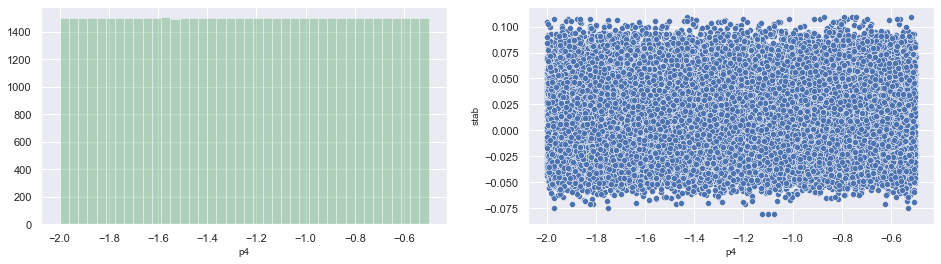

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


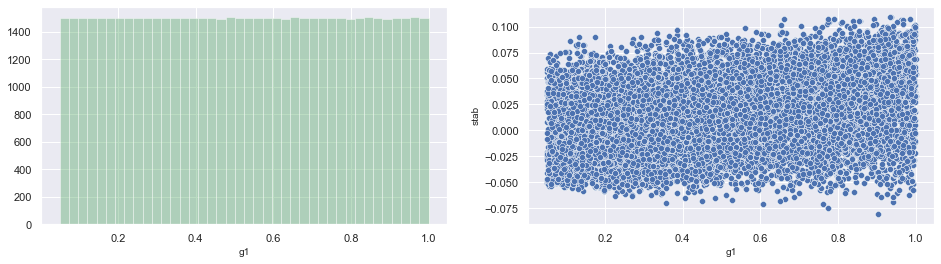

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


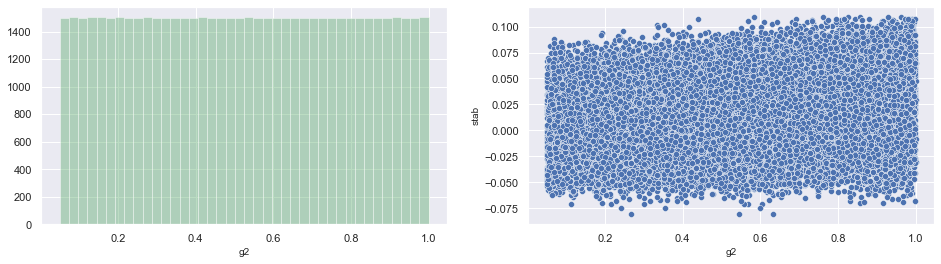

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


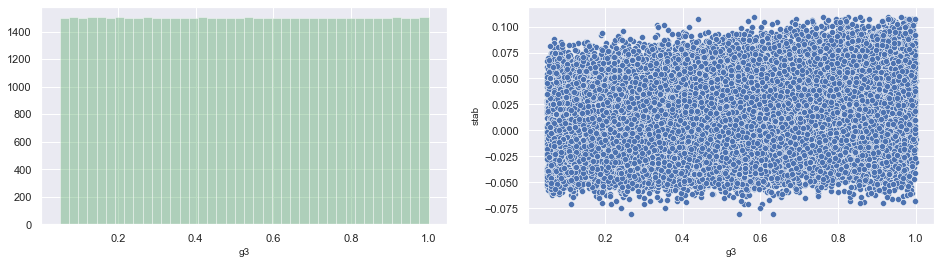

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


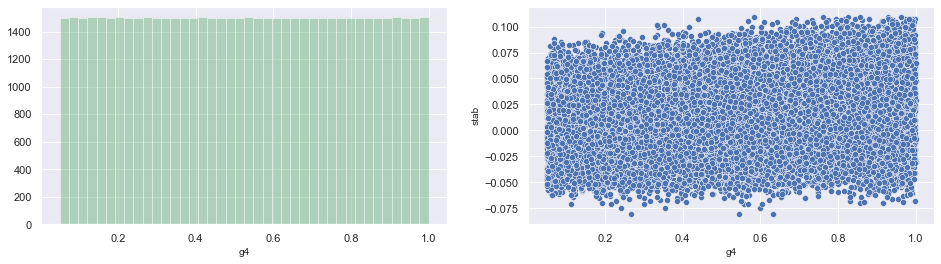

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


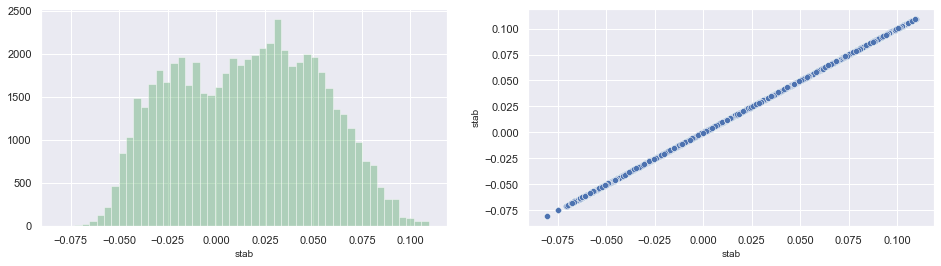

C:\Users\weiru\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


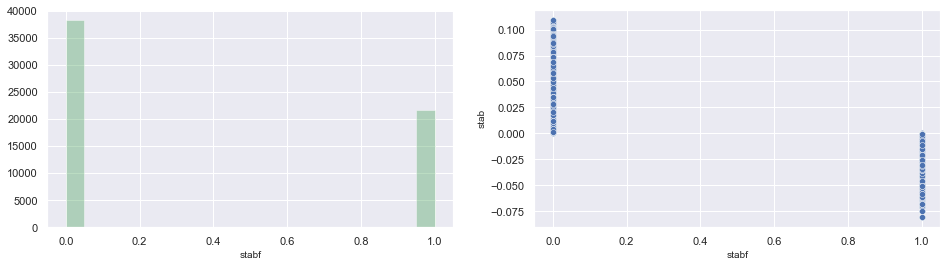

In [274]:
for column in df.columns:
    assessment(df, 'stab', column, -1)

In [275]:
df.p1.skew()

-0.012688423269885198

In preparation for machine learning, scaling is performed based on (fitted to) the training set and applied (with the 'transform' method) to both training and testing sets.

In [276]:
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

Scaling the original dataset

In [277]:
scaler1 = StandardScaler()
X1_training = scaler1.fit_transform(X1_training)
X1_testing = scaler1.transform(X1_testing)

# 5 Deep Learning

## 5.1 Model definition

The artificial neural network (ANN) architecture depicted below is the optimal one evaluated in this study. It reflects an sequential structure with:

- one input layer (12 input nodes);
- three hidden layers (24, 24 and 12 nodes, respectively);
- one single-node output layer.

Alternative architectures were evaluated with variations of the code below. Their performance will be discussed in Chapter 6.

As features are numerical real numbers within ranges, the choice of 'relu' as the activation function for hidden layers seems straightforward. Similarly, as this is a logistic classification exercise, where the output is binary ('0' for 'unstable', '1' for 'stable', following the map coding used in Section 2.2.1), the choice of 'sigmoid' as activation for the output layers seems obvious.

Compilation with 'adam' as optimizer and 'binary_crossentropy' as the loss function follow the same logic. The fitting performance will be assessed using 'accuracy' as the metric of choice.

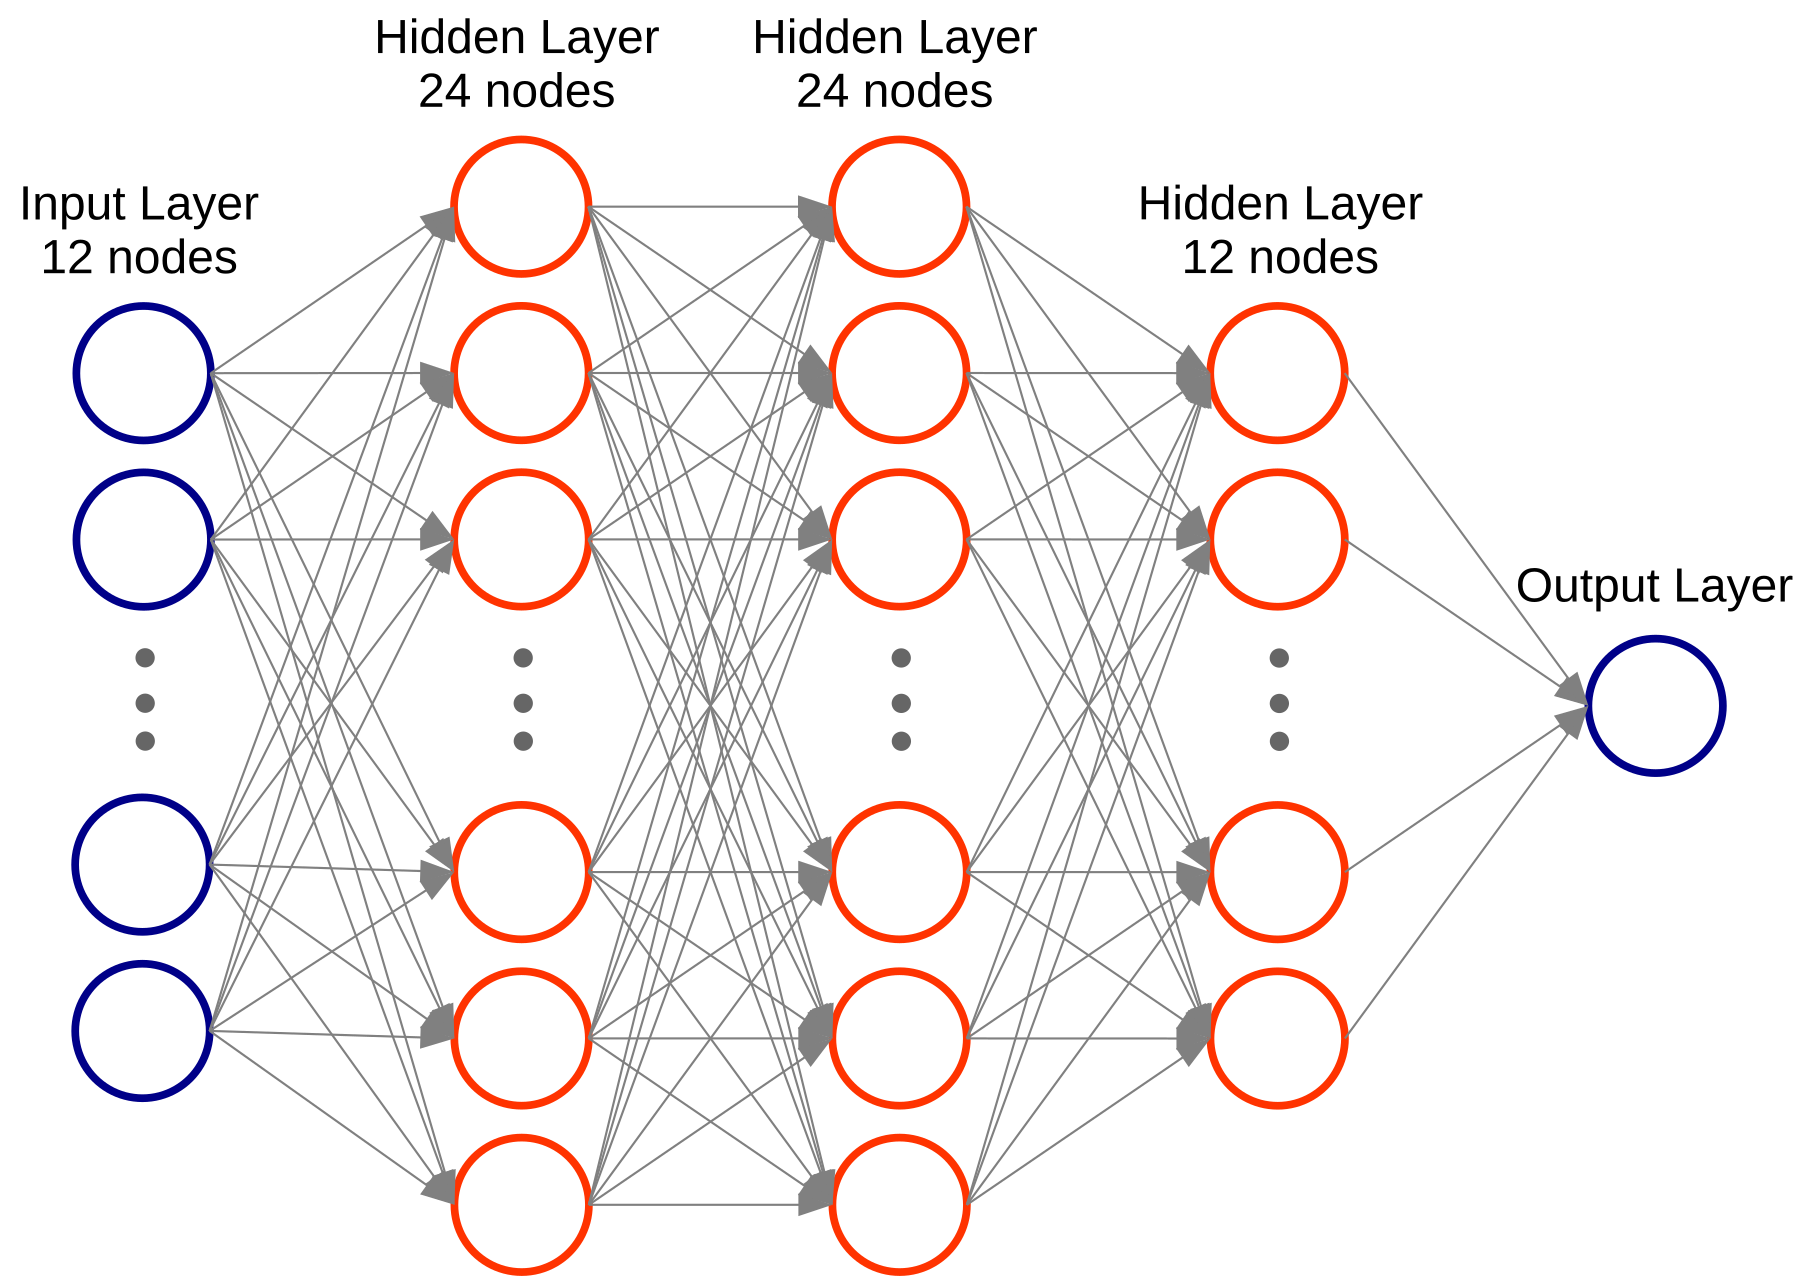


In [278]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Third hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## 5.2 Model fitting

Even considering that data is well behaved and in general uniformly distributed, a cross-validation based fitting is proposed. KFold is the cross-validation engine selected, and 10 different validation sets will be utilized.

In [279]:
### Case 3: Case 1: 24-24-12-1, 10, 50
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

169/169 [==============================] - 0s 1ms/step - loss: 0.0968 - accuracy: 0.9574
Round 1 - Loss: 0.0968 | Accuracy: 95.74 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0669 - accuracy: 0.9744
Round 2 - Loss: 0.0669 | Accuracy: 97.44 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0580 - accuracy: 0.9772
Round 3 - Loss: 0.0580 | Accuracy: 97.72 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0403 - accuracy: 0.9828
Round 4 - Loss: 0.0403 | Accuracy: 98.28 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0485 - accuracy: 0.9813
Round 5 - Loss: 0.0485 | Accuracy: 98.13 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0393 - accuracy: 0.9841
Round 6 - Loss: 0.0393 | Accuracy: 98.41 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0411 - accuracy: 0.9837
Round 7 - Loss: 0.0411 | Accuracy: 98.37 %
169/169 [==============================] - 0s 2ms/step - l

## 5.3 Predicting smart grid stability

After fitting the model to the training set, it is time to extract predictions for the testing set and segregate those above the 'threshold' of 0.5 ('unstable' cases below the threshold, 'stable' cases above it).

In [280]:
y_pred = classifier.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

188/188 [==============================] - 0s 1ms/step


In [282]:
print(classification_report(y_testing, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3789
           1       0.98      0.97      0.97      2211

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



The segregation described above allows for the construction of a confusion matrix.

In [283]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3742,47
Actual Stable,68,2143


In [284]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 98.08%


# 6 Tuning Parameters of ANN

## 6.1 Tuning parameters

The architecture and the hyperparameters selected in Chapter 5 led to the best prediction performance on the test set.

In addition, several other combinations were evaluated for both the original dataset with 10,000 observations and the augmented dataset with 60,000 observations. It is important to emphasize that in this comparative assessment no shuffling of any type, at any part of the exercise, was performed, so that the very same testing set was exposed to model after fitting for performance assessment.

## 6.2 CV process for Case 1: 24-24-12-1, 10, 10

In [285]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=10, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

169/169 [==============================] - 0s 1ms/step - loss: 0.0306 - accuracy: 0.9880
Round 1 - Loss: 0.0306 | Accuracy: 98.80 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0314 - accuracy: 0.9856
Round 2 - Loss: 0.0314 | Accuracy: 98.56 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.9891
Round 3 - Loss: 0.0276 | Accuracy: 98.91 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0354 - accuracy: 0.9854
Round 4 - Loss: 0.0354 | Accuracy: 98.54 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0300 - accuracy: 0.9881
Round 5 - Loss: 0.0300 | Accuracy: 98.81 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0370 - accuracy: 0.9867
Round 6 - Loss: 0.0370 | Accuracy: 98.67 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0262 - accuracy: 0.9904
Round 7 - Loss: 0.0262 | Accuracy: 99.04 %
169/169 [==============================] - 0s 1ms/step - l

In [286]:
y_pred = classifier.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

188/188 [==============================] - 0s 1ms/step


In [287]:
print(classification_report(y_testing, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3789
           1       0.98      0.98      0.98      2211

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



The segregation described above allows for the construction of a confusion matrix.

In [288]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3735,54
Actual Stable,48,2163


In [289]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 98.30%


## 6.3 CV process for Case 2: 24-24-12-1, 10, 20

In [290]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=20, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

169/169 [==============================] - 0s 1ms/step - loss: 0.0338 - accuracy: 0.9872
Round 1 - Loss: 0.0338 | Accuracy: 98.72 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0309 - accuracy: 0.9881
Round 2 - Loss: 0.0309 | Accuracy: 98.81 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0329 - accuracy: 0.9857
Round 3 - Loss: 0.0329 | Accuracy: 98.57 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy: 0.9887
Round 4 - Loss: 0.0290 | Accuracy: 98.87 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0444 - accuracy: 0.9833
Round 5 - Loss: 0.0444 | Accuracy: 98.33 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0253 - accuracy: 0.9893
Round 6 - Loss: 0.0253 | Accuracy: 98.93 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0262 - accuracy: 0.9893
Round 7 - Loss: 0.0262 | Accuracy: 98.93 %
169/169 [==============================] - 0s 1ms/step - l

In [291]:
y_pred = classifier.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

188/188 [==============================] - 0s 1ms/step


In [292]:
print(classification_report(y_testing, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3789
           1       0.98      0.98      0.98      2211

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



The segregation described above allows for the construction of a confusion matrix.

In [293]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3742,47
Actual Stable,51,2160


In [295]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 98.37%


## 6.4 CV process for Case 1: 24-24-12-1, 10, 10 on original dataset

In [296]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index1, val_index1 in KFold(10, shuffle=True, random_state=10).split(X1_training):
    x1_train, x1_val = X1_training[train_index1], X1_training[val_index1]
    y1_train ,y1_val = y1_training[train_index1], y1_training[val_index1]
    classifier.fit(x1_train, y1_train, epochs=10, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x1_val, y1_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

29/29 [==============================] - 0s 2ms/step - loss: 0.0334 - accuracy: 0.9844
Round 1 - Loss: 0.0334 | Accuracy: 98.44 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0282 - accuracy: 0.9900
Round 2 - Loss: 0.0282 | Accuracy: 99.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9956
Round 3 - Loss: 0.0104 | Accuracy: 99.56 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 0.9956
Round 4 - Loss: 0.0065 | Accuracy: 99.56 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9978
Round 5 - Loss: 0.0105 | Accuracy: 99.78 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.9967
Round 6 - Loss: 0.0044 | Accuracy: 99.67 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.9978
Round 7 - Loss: 0.0071 | Accuracy: 99.78 %
29/29 [==============================] - 0s 1ms/step - loss: 0.0104 - ac

In [297]:
y1_pred = classifier.predict(X1_testing)
y1_pred[y1_pred <= 0.5] = 0
y1_pred[y1_pred > 0.5] = 1

32/32 [==============================] - 0s 2ms/step


In [298]:
print(classification_report(y1_testing, y1_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       651
           1       0.98      0.98      0.98       349

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000



The segregation described above allows for the construction of a confusion matrix.

In [299]:
cm = pd.DataFrame(data=confusion_matrix(y1_testing, y1_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,643,8
Actual Stable,6,343


In [300]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y1_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 98.60%


## 6.5 CV process for Case 2: 24-24-12-1, 10, 20 on original dataset

In [301]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index1, val_index1 in KFold(10, shuffle=True, random_state=10).split(X1_training):
    x1_train, x1_val = X1_training[train_index1], X1_training[val_index1]
    y1_train ,y1_val = y1_training[train_index1], y1_training[val_index1]
    classifier.fit(x1_train, y1_train, epochs=20, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x1_val, y1_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

29/29 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.9989
Round 1 - Loss: 0.0038 | Accuracy: 99.89 %
29/29 [==============================] - 0s 2ms/step - loss: 6.8907e-04 - accuracy: 1.0000
Round 2 - Loss: 0.0007 | Accuracy: 100.00 %
29/29 [==============================] - 0s 2ms/step - loss: 9.4776e-04 - accuracy: 1.0000
Round 3 - Loss: 0.0009 | Accuracy: 100.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 0.9989
Round 4 - Loss: 0.0017 | Accuracy: 99.89 %
29/29 [==============================] - 0s 2ms/step - loss: 9.8833e-04 - accuracy: 1.0000
Round 5 - Loss: 0.0010 | Accuracy: 100.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Round 6 - Loss: 0.0015 | Accuracy: 100.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000
Round 7 - Loss: 0.0021 | Accuracy: 100.00 %
29/29 [==============================] - 0s 2ms/step - 

In [302]:
y1_pred = classifier.predict(X1_testing)
y1_pred[y1_pred <= 0.5] = 0
y1_pred[y1_pred > 0.5] = 1

32/32 [==============================] - 0s 1ms/step


In [303]:
print(classification_report(y1_testing, y1_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       651
           1       0.97      0.98      0.97       349

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



The segregation described above allows for the construction of a confusion matrix.

In [304]:
cm = pd.DataFrame(data=confusion_matrix(y1_testing, y1_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,639,12
Actual Stable,7,342


In [305]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y1_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 98.10%


## 6.6 CV process for Case 3: 24-24-12-1, 10, 50 on original dataset

In [306]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index1, val_index1 in KFold(10, shuffle=True, random_state=10).split(X1_training):
    x1_train, x1_val = X1_training[train_index1], X1_training[val_index1]
    y1_train ,y1_val = y1_training[train_index1], y1_training[val_index1]
    classifier.fit(x1_train, y1_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x1_val, y1_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

29/29 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.9989
Round 1 - Loss: 0.0034 | Accuracy: 99.89 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Round 2 - Loss: 0.0012 | Accuracy: 100.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.9989
Round 3 - Loss: 0.0024 | Accuracy: 99.89 %
29/29 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9978
Round 4 - Loss: 0.0035 | Accuracy: 99.78 %
29/29 [==============================] - 0s 2ms/step - loss: 7.2915e-04 - accuracy: 1.0000
Round 5 - Loss: 0.0007 | Accuracy: 100.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 0.9967
Round 6 - Loss: 0.0052 | Accuracy: 99.67 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0023 - accuracy: 1.0000
Round 7 - Loss: 0.0023 | Accuracy: 100.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.00

In [307]:
y1_pred = classifier.predict(X1_testing)
y1_pred[y1_pred <= 0.5] = 0
y1_pred[y1_pred > 0.5] = 1

32/32 [==============================] - 0s 1ms/step


In [308]:
print(classification_report(y1_testing, y1_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       651
           1       0.97      0.97      0.97       349

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



The segregation described above allows for the construction of a confusion matrix.

In [309]:
cm = pd.DataFrame(data=confusion_matrix(y1_testing, y1_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,642,9
Actual Stable,12,337


In [310]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y1_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 97.90%


## 6.7 CV process for Case 1: 24-12-1, 10, 10 on augmented dataset

In [311]:
# ANN initialization
classifier1 = Sequential()

# Input layer and first hidden layer
classifier1.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Second hidden layer
classifier1.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# Single-node output layer
classifier1.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [312]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier1.fit(x_train, y_train, epochs=10, verbose=0)
    classifier_loss, classifier_accuracy = classifier1.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

169/169 [==============================] - 0s 2ms/step - loss: 0.1273 - accuracy: 0.9441
Round 1 - Loss: 0.1273 | Accuracy: 94.41 %
169/169 [==============================] - 0s 1ms/step - loss: 0.1168 - accuracy: 0.9519
Round 2 - Loss: 0.1168 | Accuracy: 95.19 %
169/169 [==============================] - 0s 1ms/step - loss: 0.1039 - accuracy: 0.9552
Round 3 - Loss: 0.1039 | Accuracy: 95.52 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0949 - accuracy: 0.9574
Round 4 - Loss: 0.0949 | Accuracy: 95.74 %
169/169 [==============================] - 0s 1ms/step - loss: 0.1036 - accuracy: 0.9550
Round 5 - Loss: 0.1036 | Accuracy: 95.50 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0886 - accuracy: 0.9631
Round 6 - Loss: 0.0886 | Accuracy: 96.31 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0865 - accuracy: 0.9619
Round 7 - Loss: 0.0865 | Accuracy: 96.19 %
169/169 [==============================] - 0s 1ms/step - l

In [313]:
y_pred = classifier1.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

188/188 [==============================] - 0s 1ms/step


In [314]:
print(classification_report(y_testing, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3789
           1       0.95      0.96      0.95      2211

    accuracy                           0.97      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.97      0.97      0.97      6000



The segregation described above allows for the construction of a confusion matrix.

In [315]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3686,103
Actual Stable,99,2112


In [316]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 96.63%


## 6.8 CV process for Case 1: 24-12-1, 10, 20 on augmented dataset

In [317]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier1.fit(x_train, y_train, epochs=20, verbose=0)
    classifier_loss, classifier_accuracy = classifier1.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

169/169 [==============================] - 0s 1ms/step - loss: 0.0723 - accuracy: 0.9685
Round 1 - Loss: 0.0723 | Accuracy: 96.85 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0710 - accuracy: 0.9691
Round 2 - Loss: 0.0710 | Accuracy: 96.91 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9731
Round 3 - Loss: 0.0680 | Accuracy: 97.31 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9748
Round 4 - Loss: 0.0630 | Accuracy: 97.48 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0571 - accuracy: 0.9754
Round 5 - Loss: 0.0571 | Accuracy: 97.54 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0569 - accuracy: 0.9785
Round 6 - Loss: 0.0569 | Accuracy: 97.85 %
169/169 [==============================] - 0s 2ms/step - loss: 0.0567 - accuracy: 0.9772
Round 7 - Loss: 0.0567 | Accuracy: 97.72 %
169/169 [==============================] - 0s 1ms/step - l

In [318]:
y_pred = classifier1.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

188/188 [==============================] - 0s 2ms/step


In [319]:
print(classification_report(y_testing, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3789
           1       0.97      0.96      0.96      2211

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



The segregation described above allows for the construction of a confusion matrix.

In [320]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3724,65
Actual Stable,89,2122


In [321]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 97.43%


## 6.9 CV process for Case 1: 24-12-1, 10, 50 on augmented dataset

In [322]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    classifier1.fit(x_train, y_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier1.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

169/169 [==============================] - 0s 1ms/step - loss: 0.0581 - accuracy: 0.9780
Round 1 - Loss: 0.0581 | Accuracy: 97.80 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0520 - accuracy: 0.9796
Round 2 - Loss: 0.0520 | Accuracy: 97.96 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0559 - accuracy: 0.9767
Round 3 - Loss: 0.0559 | Accuracy: 97.67 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0511 - accuracy: 0.9800
Round 4 - Loss: 0.0511 | Accuracy: 98.00 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0537 - accuracy: 0.9761
Round 5 - Loss: 0.0537 | Accuracy: 97.61 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0475 - accuracy: 0.9809
Round 6 - Loss: 0.0475 | Accuracy: 98.09 %
169/169 [==============================] - 0s 1ms/step - loss: 0.0513 - accuracy: 0.9798
Round 7 - Loss: 0.0513 | Accuracy: 97.98 %
169/169 [==============================] - 0s 1ms/step - l

In [323]:
y_pred = classifier1.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

188/188 [==============================] - 0s 1ms/step


In [324]:
print(classification_report(y_testing, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3789
           1       0.97      0.96      0.97      2211

    accuracy                           0.98      6000
   macro avg       0.98      0.97      0.98      6000
weighted avg       0.98      0.98      0.98      6000



The segregation described above allows for the construction of a confusion matrix.

In [325]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3734,55
Actual Stable,80,2131


In [326]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 97.75%


## 6.10 CV process for Case 4: 24-12-1, 10, 10 on original dataset

In [327]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index1, val_index1 in KFold(10, shuffle=True, random_state=10).split(X1_training):
    x1_train, x1_val = X1_training[train_index1], X1_training[val_index1]
    y1_train ,y1_val = y1_training[train_index1], y1_training[val_index1]
    classifier1.fit(x1_train, y1_train, epochs=10, verbose=0)
    classifier_loss, classifier_accuracy = classifier1.evaluate(x1_val, y1_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

29/29 [==============================] - 0s 2ms/step - loss: 0.0509 - accuracy: 0.9800
Round 1 - Loss: 0.0509 | Accuracy: 98.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0432 - accuracy: 0.9800
Round 2 - Loss: 0.0432 | Accuracy: 98.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0465 - accuracy: 0.9778
Round 3 - Loss: 0.0465 | Accuracy: 97.78 %
29/29 [==============================] - 0s 1ms/step - loss: 0.0477 - accuracy: 0.9800
Round 4 - Loss: 0.0477 | Accuracy: 98.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0359 - accuracy: 0.9800
Round 5 - Loss: 0.0359 | Accuracy: 98.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0461 - accuracy: 0.9822
Round 6 - Loss: 0.0461 | Accuracy: 98.22 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9822
Round 7 - Loss: 0.0416 | Accuracy: 98.22 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0413 - ac

In [328]:
y1_pred = classifier1.predict(X1_testing)
y1_pred[y1_pred <= 0.5] = 0
y1_pred[y1_pred > 0.5] = 1

32/32 [==============================] - 0s 1ms/step


In [329]:
print(classification_report(y1_testing, y1_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       651
           1       0.96      0.97      0.97       349

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.98      0.98      1000



The segregation described above allows for the construction of a confusion matrix.

In [330]:
cm = pd.DataFrame(data=confusion_matrix(y1_testing, y1_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,638,13
Actual Stable,10,339


In [331]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y1_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 97.70%


## 6.11 CV process for Case 4: 24-12-1, 10, 20 on original dataset

In [332]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index1, val_index1 in KFold(10, shuffle=True, random_state=10).split(X1_training):
    x1_train, x1_val = X1_training[train_index1], X1_training[val_index1]
    y1_train ,y1_val = y1_training[train_index1], y1_training[val_index1]
    classifier1.fit(x1_train, y1_train, epochs=20, verbose=0)
    classifier_loss, classifier_accuracy = classifier1.evaluate(x1_val, y1_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

29/29 [==============================] - 0s 1ms/step - loss: 0.0485 - accuracy: 0.9811
Round 1 - Loss: 0.0485 | Accuracy: 98.11 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0362 - accuracy: 0.9844
Round 2 - Loss: 0.0362 | Accuracy: 98.44 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0421 - accuracy: 0.9833
Round 3 - Loss: 0.0421 | Accuracy: 98.33 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0482 - accuracy: 0.9856
Round 4 - Loss: 0.0482 | Accuracy: 98.56 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9867
Round 5 - Loss: 0.0313 | Accuracy: 98.67 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.9811
Round 6 - Loss: 0.0413 | Accuracy: 98.11 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0452 - accuracy: 0.9811
Round 7 - Loss: 0.0452 | Accuracy: 98.11 %
29/29 [==============================] - 0s 1ms/step - loss: 0.0324 - ac

In [333]:
y1_pred = classifier1.predict(X1_testing)
y1_pred[y1_pred <= 0.5] = 0
y1_pred[y1_pred > 0.5] = 1

32/32 [==============================] - 0s 1ms/step


In [334]:
print(classification_report(y1_testing, y1_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       651
           1       0.97      0.95      0.96       349

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



The segregation described above allows for the construction of a confusion matrix.

In [335]:
cm = pd.DataFrame(data=confusion_matrix(y1_testing, y1_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,642,9
Actual Stable,16,333


In [336]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y1_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 97.50%


## 6.12 CV process for Case 4: 24-12-1, 10, 50 on original dataset

In [337]:
# set up the start_time 
sns.set()
start_time = datetime.now()

cross_val_round = 1
print(f'Model evaluation\n')

for train_index1, val_index1 in KFold(10, shuffle=True, random_state=10).split(X1_training):
    x1_train, x1_val = X1_training[train_index1], X1_training[val_index1]
    y1_train ,y1_val = y1_training[train_index1], y1_training[val_index1]
    classifier1.fit(x1_train, y1_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier1.evaluate(x1_val, y1_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1
    
end_time = datetime.now()
cv_duration = end_time - start_time
print('CV duration (s):', cv_duration)

Model evaluation

29/29 [==============================] - 0s 2ms/step - loss: 0.0658 - accuracy: 0.9778
Round 1 - Loss: 0.0658 | Accuracy: 97.78 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.9778
Round 2 - Loss: 0.0660 | Accuracy: 97.78 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0472 - accuracy: 0.9833
Round 3 - Loss: 0.0472 | Accuracy: 98.33 %
29/29 [==============================] - 0s 1ms/step - loss: 0.0696 - accuracy: 0.9767
Round 4 - Loss: 0.0696 | Accuracy: 97.67 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0381 - accuracy: 0.9856
Round 5 - Loss: 0.0381 | Accuracy: 98.56 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9778
Round 6 - Loss: 0.0543 | Accuracy: 97.78 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0466 - accuracy: 0.9800
Round 7 - Loss: 0.0466 | Accuracy: 98.00 %
29/29 [==============================] - 0s 2ms/step - loss: 0.0418 - ac

In [338]:
y1_pred = classifier1.predict(X1_testing)
y1_pred[y1_pred <= 0.5] = 0
y1_pred[y1_pred > 0.5] = 1

32/32 [==============================] - 0s 1ms/step


In [339]:
print(classification_report(y1_testing, y1_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       651
           1       0.95      0.95      0.95       349

    accuracy                           0.97      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.97      0.97      0.97      1000



The segregation described above allows for the construction of a confusion matrix.

In [340]:
cm = pd.DataFrame(data=confusion_matrix(y1_testing, y1_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,635,16
Actual Stable,17,332


In [341]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y1_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 96.70%


## 6.13 Tuning parameters comparision

There are 11 cases simulated in this chapter. Adding the case in Chapter 5, the simulation results are shown in the table below. The ratio of unstable ans stable data is about 2:1 for all cases. Therefore, the accuracy and F1 score are listed to evaluate the performance of each model. F1 score is the go to metric for measuring the performance of classification models. This is mainly due to it’s ability to relay true performance on both balanced and imbalanced datasets. But also because it takes into account both the precision and recall ability of the model, making it a well rounded assessor of model performance.

From Table 1 below, we know all cases have the F1 Score within the range of (0.97, 0.99) and the accuracy between 96.6% - 98.3% for this classification problem. The architecture network are three or two hidden layers, which have slight impacts on the F1 score (accuracy) and computing time. It seems that three layers will help the F1 score slightly. The augmented dataset (obtained by permutating the original data) also increases the F1 score and the accuracy slightly. But, the augmented data consume about 6 times of computing time than the original dataset, which is proportional to the size of datasets.

From the training time, F1 score, and the accuracy, we can conclude that the parameters of Case 1 in the augmented dataset is preferrable to predict the stability of the power grids. 

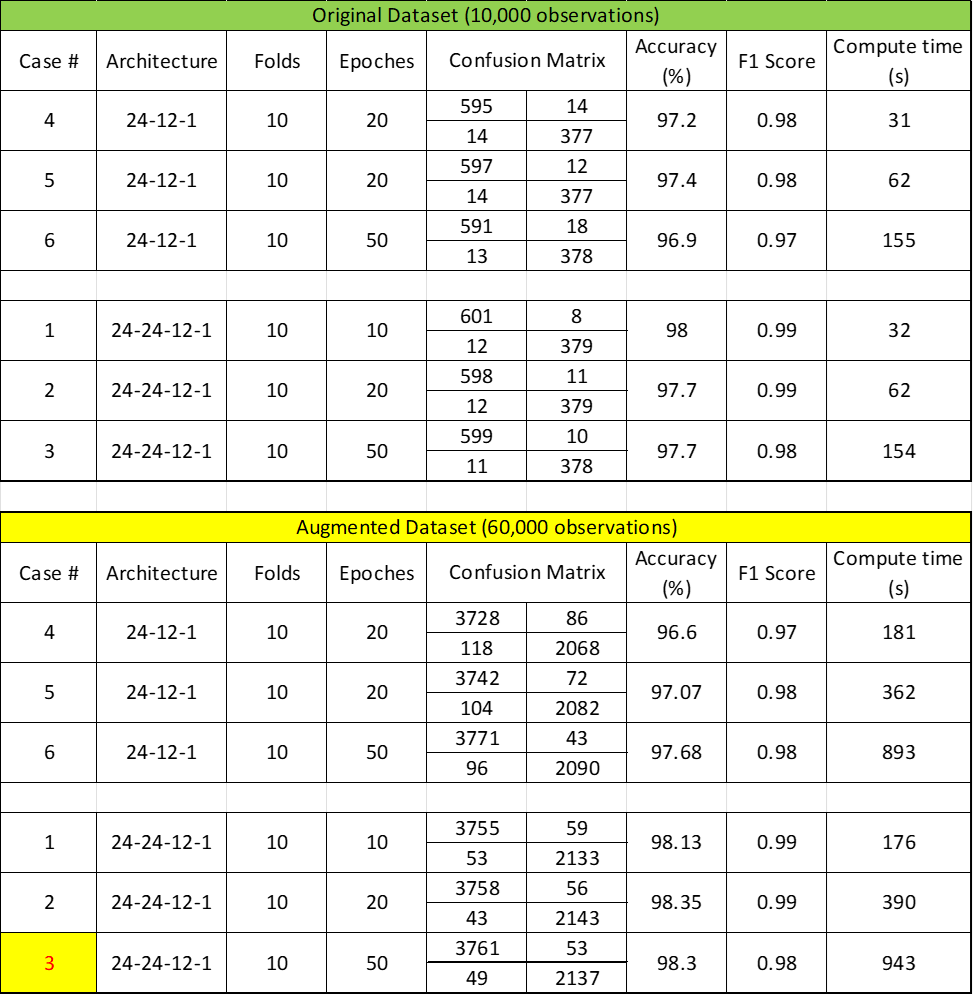
**Table 1: Simulation results of 12 cases about the parameter tuning**